## Creating Network-Based Profiles of Methylmalonyl-CoA Mutase Deficiency

Methylmalonic aciduria (MMA) is an inborn-error of metabolism classically caused by autosomal recessive mutations in ~20 genes which results in accumulation of methylmalonic acid.

To better understand the underlying pathogenesis of MMA, [Forny et. al., 2023](https://www.nature.com/articles/s42255-022-00720-8) profiled fibroblasts from 210 affected individuals and 20 controls using transcriptomics and proteomics.

To evaluate whether Napistu could be useful for characterizing the molecular biology and biochemistry of datasets like this, we sought to develop network-based signatures of MMA. This involves:

1. Loading the transcriptomics and proteomics datasets and formatting them as a [MuData object](https://mudata.readthedocs.io/en/latest/).
2. Log-transforming and filtering to well-measured features.
3. Normalization to row and column center the data, as per the original paper.
4. Performing exploratory data analysis to characterize the major patterns of variation in the datasets and how they relate to sample metadata attributes.
5. Creating molecular profiles containing sets of functionally-related transcripts & proteins.
    a. Our supervised approach involves fitting feature-wise regressions
    b. Our unsupervised approach involves using factor analysis to extra multiple correlated gene/protein expression programs. We can then regress these program usages on covariates of interest.
6. Bind each molecular profile to a Napistu network and harmonize the findings using personalized pagerank.

Before getting started we'll load packages and set global variables like paths.

In [1]:
import os

import anndata as ad
import matplotlib.pyplot as plt
from mudata import MuData
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import KNNImputer

# import local modules
import phenotypes
import processing
import profiles
import eda
import factor_analysis

/Users/maya/Desktop/GITHUB/napistu/lib/napistu-scrapyard/applications/forny_2023/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# paths
PROJECT_DIR =  os.path.expanduser("~/Desktop/Data/Forny_2023")
SUPPLEMENTAL_DATA_DIR = os.path.join(PROJECT_DIR, "input")
CACHE_DIR = os.path.join(PROJECT_DIR, "cache")

# Define the path to save hyperparameter scan results
MOFA_PARAM_SCAN_MODELS_PATH = os.path.join(CACHE_DIR, "mofa_param_scan_h5mu")
# Final results 
OPTIMAL_MODEL_H5MU_PATH = os.path.join(CACHE_DIR, "mofa_optimal_model.h5mu")

# formats
SUPPLEMENTAL_DATA_FILES = {
    "transcriptomics" : {
        "file" : "42255_2022_720_MOESM3_ESM.xlsx",
        "sheet" : "Source Data transcriptomics"
    },
    "proteomics" : {
        "file" : "42255_2022_720_MOESM3_ESM.xlsx",
        "sheet" : "Source Data proteomics"
    },
    "phenotypes" : {
        "file" : "42255_2022_720_MOESM4_ESM.xlsx",
        "sheet" : 0
    }
}

# globals
# filter genes with fewer than this # of counts summed over samples
READ_CUTOFF = int(400)
# measure to use for analysis
ANALYSIS_LAYER = "log2_centered"
# regression formula for feature-level and factor-level regression
REGRESSION_FORMULA = "~ case + gender"
# cutoff for FDR-adjusted p-values
FDR_CUTOFF = 0.1
# Define the range of factors to test for MOFA
FACTOR_RANGE = range(4, 51, 2)
# Overwrite the results if they already exist   
OVERWRITE = False
# Define the optimal number of factors
OPTIMAL_FACTOR = int(30)

Now, we can load the individual datasets as pd.DataFrames. I'm going to track these tables in a dict but its not really necessary.

In [3]:
# load
supplemental_data_path = {
    x : {
        "path" : os.path.join(SUPPLEMENTAL_DATA_DIR, y["file"]),
        "sheet" : y["sheet"]
    }
        for x, y in SUPPLEMENTAL_DATA_FILES.items()
}

assert all([os.path.isfile(x["path"]) for x in supplemental_data_path.values()])

supplemental_data = {
    x : pd.read_excel(y["path"], sheet_name = y["sheet"]) for x, y in supplemental_data_path.items()
}

In [4]:
# formatting
supplemental_data["transcriptomics"] = supplemental_data["transcriptomics"].rename({"Unnamed: 0" : "ensembl_gene"}, axis = 1).set_index("ensembl_gene")
supplemental_data["proteomics"] = supplemental_data["proteomics"].rename({"PG.ProteinAccessions" : "uniprot"}, axis = 1).set_index("uniprot")
supplemental_data["phenotypes"] = supplemental_data["phenotypes"].rename({"Unnamed: 0" : "patient_id"}, axis = 1).set_index("patient_id")

In [5]:
supplemental_data["transcriptomics"].head()

,MMA001,MMA002,MMA003,MMA004,MMA005,MMA006,MMA007,MMA008,MMA009,MMA010,...,MMA220,MMA222,MMA223,MMA224,MMA225,MMA226,MMA227,MMA228,MMA229,MMA230
ensembl_gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000187634,1.873615,1.505270,0.986076,1.123403,5.806861,1.431328,1.251731,9.403244,1.353007,1.174570,...,12.565674,5.229523,6.640500,3.129463,1.731466,1.518375,1.121370,1.922590,3.458497,0.989769
ENSG00000188976,13.627592,7.954398,7.072510,7.722724,11.079538,6.171506,6.466709,12.337651,11.094306,5.950285,...,17.705565,9.782707,9.526287,7.936750,6.794779,8.044985,7.041855,8.283558,11.754802,7.057638
ENSG00000187961,1.037994,0.552903,0.436914,0.738782,1.691288,0.438173,0.606665,0.985185,1.486020,0.152516,...,0.839992,0.810122,0.458880,0.343265,0.510889,0.270509,0.218708,0.439597,0.429895,0.604521
ENSG00000187583,0.698824,0.041128,0.024047,0.061751,0.238684,0.037082,0.019218,0.483886,0.058053,0.030468,...,0.862213,0.126554,0.429522,0.041436,0.042376,0.000000,0.076661,0.000000,0.012485,0.014054
ENSG00000187642,0.166474,0.403885,0.033554,0.083613,0.069547,0.042103,0.041908,0.117374,0.019715,0.007449,...,0.185598,0.027146,0.098651,0.000000,0.026749,0.000000,0.011748,0.000000,0.000000,0.023950


In [6]:
supplemental_data["transcriptomics"]

# i'm not sure what these units are - they don't look like counts (too many non-integers) and the col-sums are not constant across samples
# supplemental_data["transcriptomics"].sum(axis = 0).hist()

,MMA001,MMA002,MMA003,MMA004,MMA005,MMA006,MMA007,MMA008,MMA009,MMA010,...,MMA220,MMA222,MMA223,MMA224,MMA225,MMA226,MMA227,MMA228,MMA229,MMA230
ensembl_gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000187634,1.873615,1.505270,0.986076,1.123403,5.806861,1.431328,1.251731,9.403244,1.353007,1.174570,...,12.565674,5.229523,6.640500,3.129463,1.731466,1.518375,1.121370,1.922590,3.458497,0.989769
ENSG00000188976,13.627592,7.954398,7.072510,7.722724,11.079538,6.171506,6.466709,12.337651,11.094306,5.950285,...,17.705565,9.782707,9.526287,7.936750,6.794779,8.044985,7.041855,8.283558,11.754802,7.057638
ENSG00000187961,1.037994,0.552903,0.436914,0.738782,1.691288,0.438173,0.606665,0.985185,1.486020,0.152516,...,0.839992,0.810122,0.458880,0.343265,0.510889,0.270509,0.218708,0.439597,0.429895,0.604521
ENSG00000187583,0.698824,0.041128,0.024047,0.061751,0.238684,0.037082,0.019218,0.483886,0.058053,0.030468,...,0.862213,0.126554,0.429522,0.041436,0.042376,0.000000,0.076661,0.000000,0.012485,0.014054
ENSG00000187642,0.166474,0.403885,0.033554,0.083613,0.069547,0.042103,0.041908,0.117374,0.019715,0.007449,...,0.185598,0.027146,0.098651,0.000000,0.026749,0.000000,0.011748,0.000000,0.000000,0.023950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000099725,0.000000,0.000000,0.015544,0.369560,1.107666,0.425329,0.000000,0.000000,0.000000,0.000000,...,0.316457,0.005195,0.341058,0.453275,0.000000,0.366223,0.491734,0.417040,0.000000,0.557731
ENSG00000114374,0.000000,0.000000,0.000000,1.170908,1.894446,1.925946,0.000000,0.000000,0.000000,0.000000,...,2.240075,0.000000,1.166122,1.800749,0.000000,1.446769,2.278580,1.139112,0.001574,1.616639
ENSG00000067048,0.000000,0.000000,0.000000,7.852414,13.277866,18.192403,0.000000,0.000000,0.000000,0.000000,...,9.390433,0.000000,8.295066,12.885792,0.000000,7.398381,10.489536,3.742999,0.000000,8.186472


In [7]:
supplemental_data["proteomics"].head()

,PG.ProteinDescriptions,PG.ProteinNames,PG.Qvalue,MMA001,MMA002,MMA003,MMA004,MMA005,MMA006,MMA007,...,MMA221,MMA222,MMA223,MMA224,MMA225,MMA226,MMA227,MMA228,MMA229,MMA230
uniprot,,,,,,,,,,,,,,,,,,,,,
A0AVF1,Intraflagellar transport protein 56,IFT56_HUMAN,0.005996,83727.578125,119782.273438,435030.031250,351463.812500,473821.687500,462218.531250,461786.062500,...,96052.937500,203895.218750,367420.562500,128790.132812,258611.218750,236174.890625,281066.500000,57388.179688,21557.371094,165707.18750
A0AVT1,Ubiquitin-like modifier-activating enzyme 6,UBA6_HUMAN,0.000085,37115.953125,46101.957031,65014.164062,71438.554688,42789.007812,41797.777344,40118.589844,...,42814.156250,49667.570312,36617.558594,63397.425781,51176.625000,42973.957031,55355.019531,33448.113281,42359.183594,45239.43750
A0FGR8,Extended synaptotagmin-2,ESYT2_HUMAN,0.000017,40237.117188,217922.515625,197898.968750,122243.023438,152602.468750,170386.234375,158019.125000,...,160844.015625,131429.296875,147733.250000,130756.320312,181981.031250,110166.304688,131816.656250,139880.625000,199221.109375,108320.78125
A1AG_BOVINAlpha-1-acidglycoproteinOS=BostaurusGN=ORM1PE=2SV=1;CONT_Q3SZR3,;(Bos taurus) Alpha-1-acid glycoprotein precursor,NaN,0.000001,46269.468750,456155.343750,76156.734375,70375.281250,71832.406250,88579.406250,80614.843750,...,199413.093750,137026.562500,268573.125000,290260.312500,282464.937500,443858.531250,770606.937500,227444.343750,495527.593750,439083.68750
A1L0T0,Acetolactate synthase-like protein,ILVBL_HUMAN,0.000017,55125.847656,63051.160156,31387.976562,40272.636719,49587.910156,39840.132812,37784.460938,...,57427.914062,77553.562500,42669.714844,61045.855469,34615.488281,37323.367188,65609.390625,62056.046875,52899.207031,36870.06250


In [8]:
supplemental_data["phenotypes"].head()

,case,gender,n_passage,date_collection,date_freezing,consanguinity,onset_age,OHCblMinus,OHCblPlus,ratio,...,cssModif,irritability,hyperventilation,hypothermia,somnolence,vomiting,dehydration,feeding_problem,GFR,responsive_to_acute_treatment
patient_id,,,,,,,,,,,,,,,,,,,,,
MMA001,1,1,3.0,2001,2001,0,28.0,256.0,468.0,1.83,...,1,0,0,0,0,0,0,0,NaN,1
MMA002,1,1,3.0,2001,2001,1,1.0,1610.0,1544.0,0.96,...,2,0,0,0,0,0,1,1,NaN,0
MMA003,1,1,7.0,1991,1996,1,3.0,101.0,76.0,0.76,...,2,0,1,1,0,0,1,0,NaN,0
MMA004,1,0,5.0,1995,1996,0,3.0,220.0,219.0,1.00,...,2,0,0,0,0,0,0,0,NaN,1
MMA005,1,0,3.0,1995,1996,0,1.0,1830.0,1968.0,1.08,...,1,0,0,0,0,0,0,0,NaN,0


## Defining Measures of MMA Severity

To identify features and gene programs associated with MMA, we need some categorical or continuous measures of disease severity. One categorical measure we can evaluate is case vs. control. Many studies use this measure because A vs. B comparisons are easy to reason about and for better or worse they mask much of the complexity of disease (comorbidies, mis-diagnosis, varying severity). This measure isn't ideal for the Forny dataset because the study is highly imbalanced with only 20 controls for 210 cases. Still, we can evaluate if the cases are systematically different from the controls (spoiler, they aren't). 

Alternatively, we can use continuous measures, particularly molecular ones, to quantitatively define disease severity. A priori, `OHCblPlus` is such a quality measure as it is measured in the majority of the cohort and its a read-out of propionate incorporation into amino acids which is close to MMA's unerlying etiology. Others may be useful as well to capture complementary aspects of the disease biology, or depending on the patterns of missing data, to more accurately impute the value of key attributes.

The goal of this section will be to:
1. identify other measures like `OHCblPlus` which may capture complementary aspects of MMA's etiology.
2. transform continuous measures so they we can make assumptions are normality (bivariate normality for correlation; residual normality for regression).
3. if possible, impute missing values so relevant phenotypes are defined for all samples with 'omics. 

### Individual Phenotypes

First, we can look at some individual phenotypes of interest.

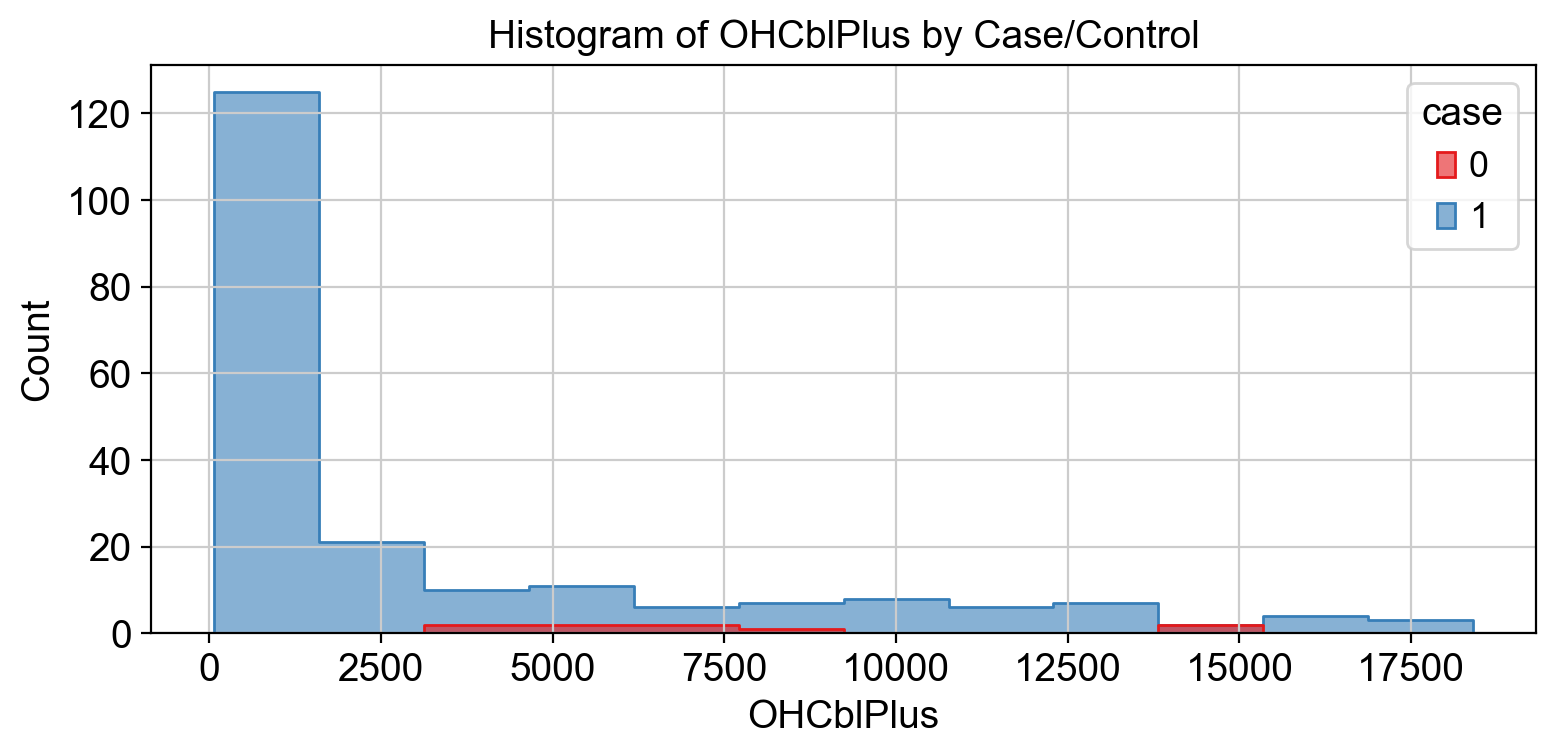

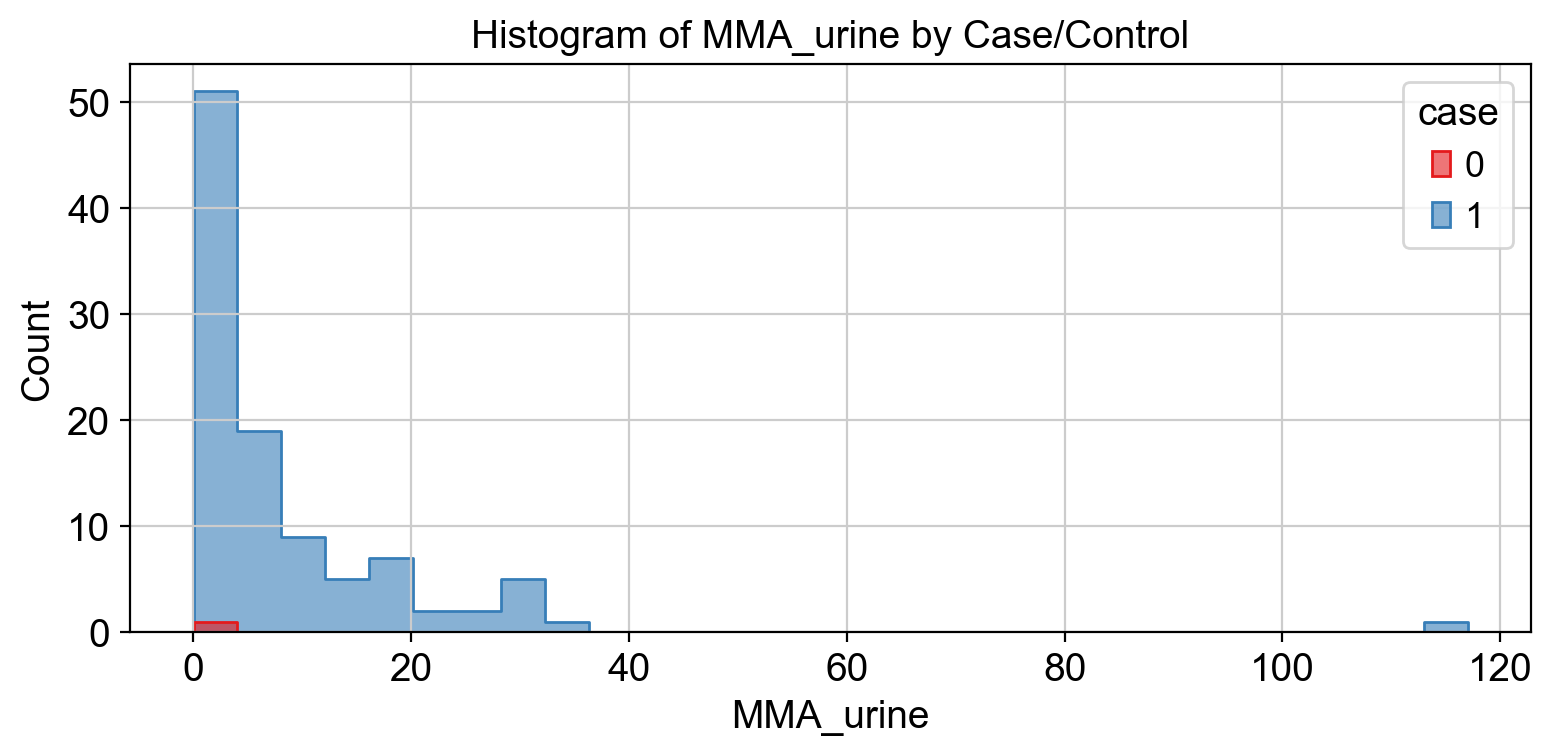

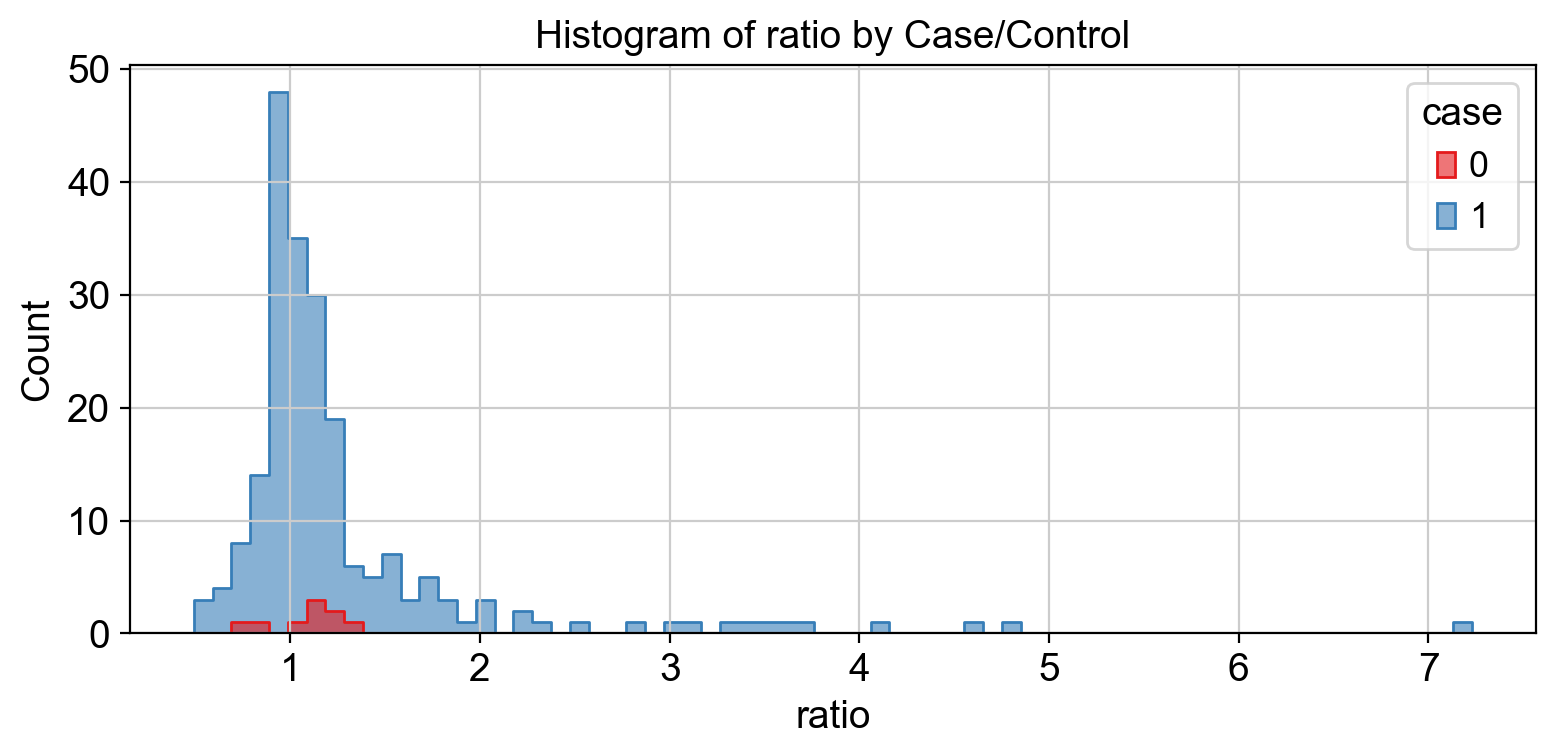

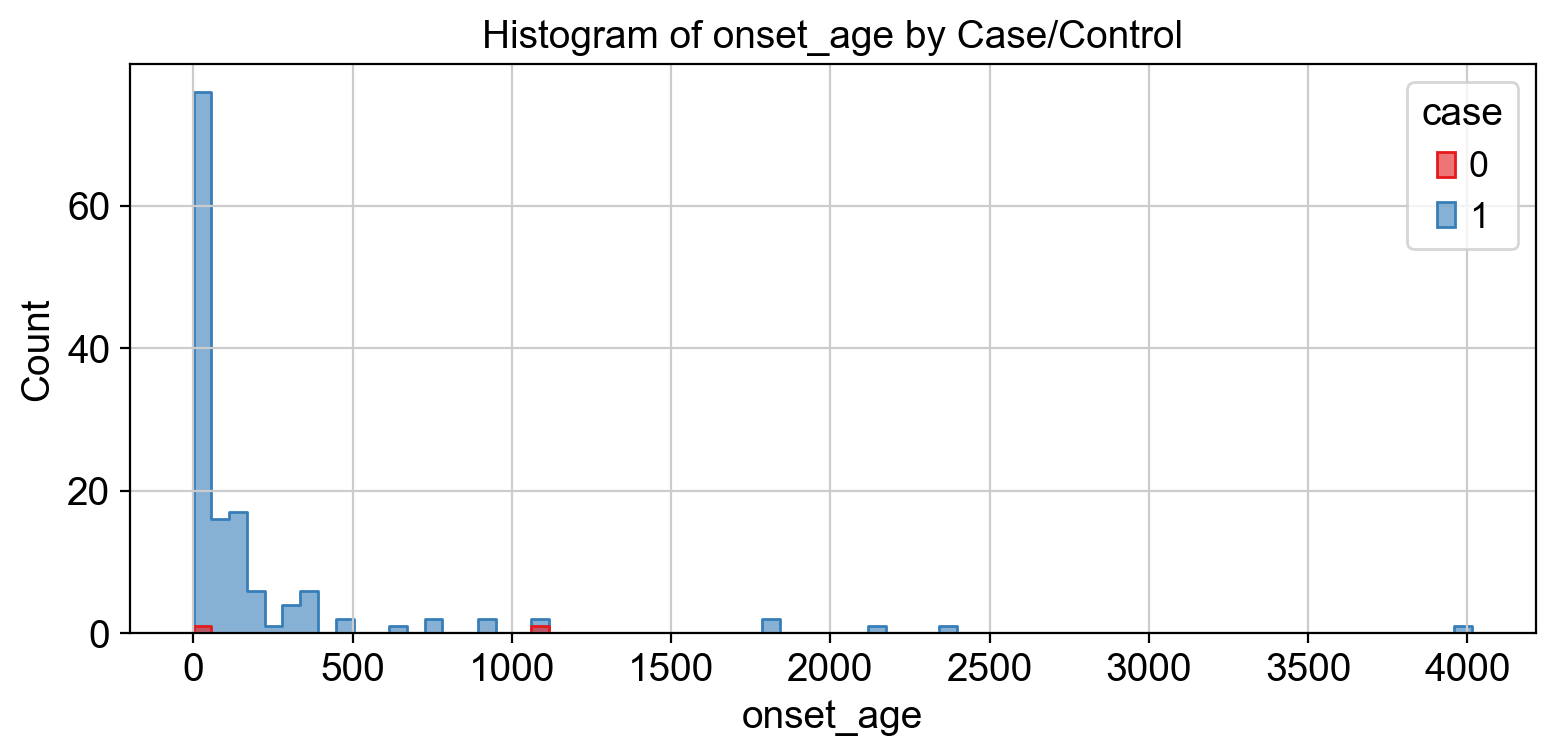

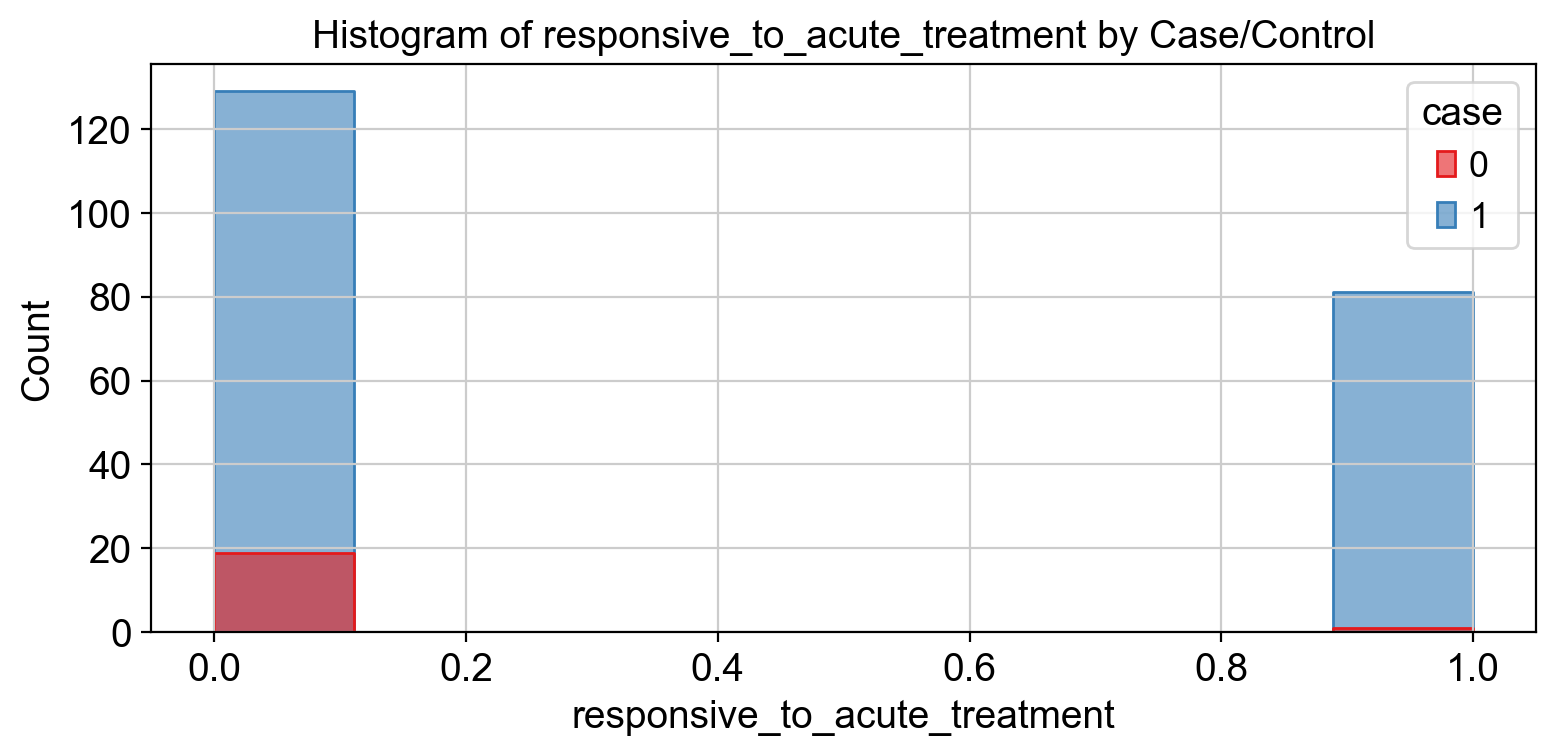

In [9]:
# Choose your continuous variables
DIEASE_MEASURES = {"case", "onset_age", "OHCblPlus", "ratio", "responsive_to_acute_treatment", "MMA_urine"}

for var in DIEASE_MEASURES.difference({"case"}):
    plt.figure(figsize=(8, 4))
    ax = sns.histplot(
        data=supplemental_data["phenotypes"],
        x=var,
        hue="case",
        element="step",
        stat="count",  # show raw counts
        common_norm=False,
        palette="Set1",
        alpha=0.6
    )
    plt.title(f"Histogram of {var} by Case/Control")
    plt.xlabel(var)
    plt.ylabel("Count")
    # Use the legend generated by seaborn
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(title="Case")
    plt.tight_layout()
    plt.show()

Looking at individual measures we can see that many are positively skewed so some form of transformation is called for before applying correlation- or regression-based analysis.

### Patterns of Missing Data

Since some attributes are missing, we may be able to infer these values the broader correlation structure of phenotypes. To evaluate how to impute missing data, we should look at the patterns of missing phenotypes. Phenotypes which are missing in the vast majority of samples are probably not useful at all, while phenotypes which are always missing together will not be useful for imputing one-another.

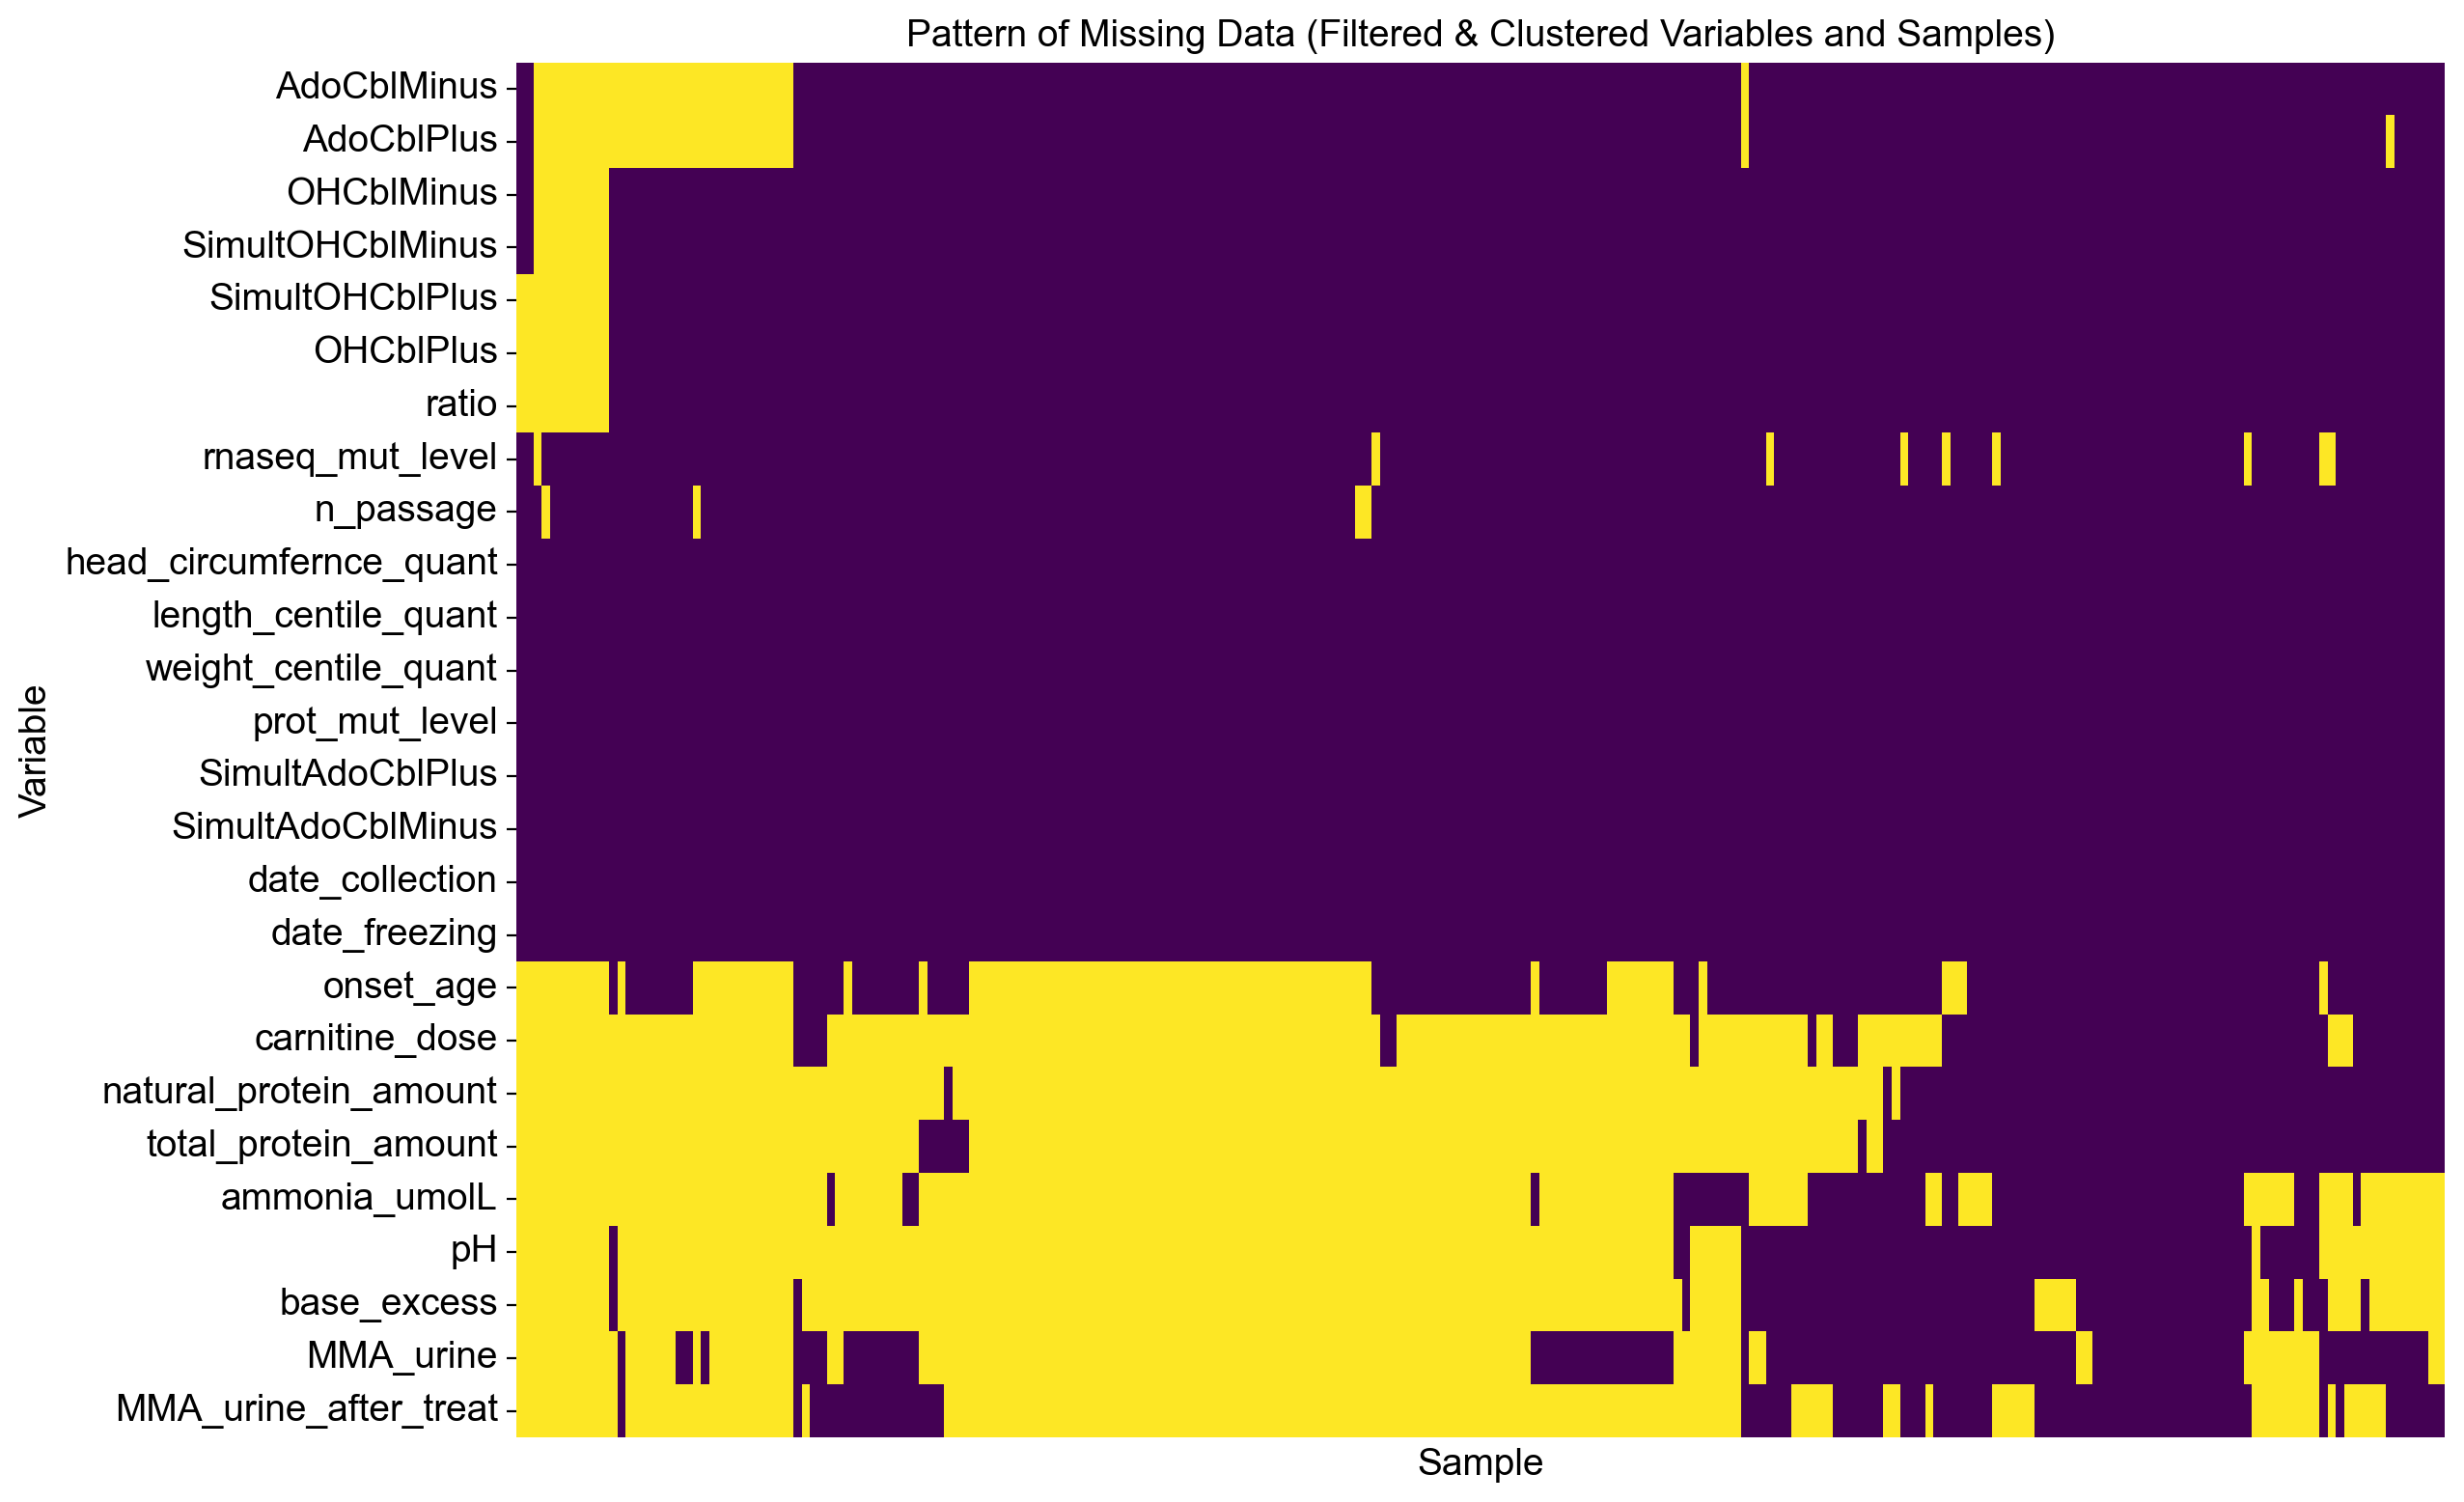

In [10]:
MAX_MISSING_PHENOTYPE = int(180)

phenotypes.plot_clustered_missing_pattern(supplemental_data["phenotypes"], max_missing = MAX_MISSING_PHENOTYPE)

From the plot we can see there are ~20 continuous measures which may be useful as disease surrogates and/or for imputation.

###  Transforming Continuous Measures

Next, we can transform continuous measures so they more closely follow a Normal distribution. In some cases this may not be appropriate, for example if the measure is truely bimodal, but we can evaluate the biological appropriateness of the transformation based on its ability to recall disease signatures. For example, a measure which more closely reflect the underlying biology may yield more significant discoveries in differential expression analysis or show higher correleation to the leading principal components during exploratory data analysis.

In [11]:
continuous_df = phenotypes._select_continuous_measures(supplemental_data["phenotypes"], max_missing = MAX_MISSING_PHENOTYPE)

normalizing_transforms = {}
for col in continuous_df.columns:
    normalizing_transforms[col] = phenotypes.best_normalizing_transform(continuous_df[col])["best"]

normalizing_transforms

/Users/maya/Desktop/GITHUB/napistu/lib/napistu-scrapyard/applications/forny_2023/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


{'n_passage': 'boxcox',
 'date_collection': 'yeo-johnson',
 'date_freezing': 'yeo-johnson',
 'onset_age': 'log2',
 'OHCblMinus': 'yeo-johnson',
 'OHCblPlus': 'yeo-johnson',
 'ratio': 'yeo-johnson',
 'SimultOHCblMinus': 'boxcox',
 'SimultOHCblPlus': 'boxcox',
 'AdoCblMinus': 'arcsinh',
 'AdoCblPlus': 'boxcox',
 'SimultAdoCblMinus': 'yeo-johnson',
 'SimultAdoCblPlus': 'yeo-johnson',
 'prot_mut_level': 'yeo-johnson',
 'rnaseq_mut_level': 'yeo-johnson',
 'MMA_urine': 'boxcox',
 'ammonia_umolL': 'log2',
 'pH': 'yeo-johnson',
 'base_excess': 'original',
 'MMA_urine_after_treat': 'yeo-johnson',
 'carnitine_dose': 'log2',
 'natural_protein_amount': 'yeo-johnson',
 'total_protein_amount': 'arcsinh',
 'weight_centile_quant': 'sqrt',
 'length_centile_quant': 'sqrt',
 'head_circumfernce_quant': 'original'}

In [12]:

func_transform_dict = {col: phenotypes.transform_func_map[trans] for col, trans in normalizing_transforms.items()}

# Apply transformation
transformed_df = phenotypes.transform_columns(continuous_df, func_transform_dict)

/Users/maya/Desktop/GITHUB/napistu/lib/napistu-scrapyard/applications/forny_2023/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


### Multivariate Analysis and Imputation

Now that we've found appropriate transformations for the continuous variables we can inspect their correlation structure. 

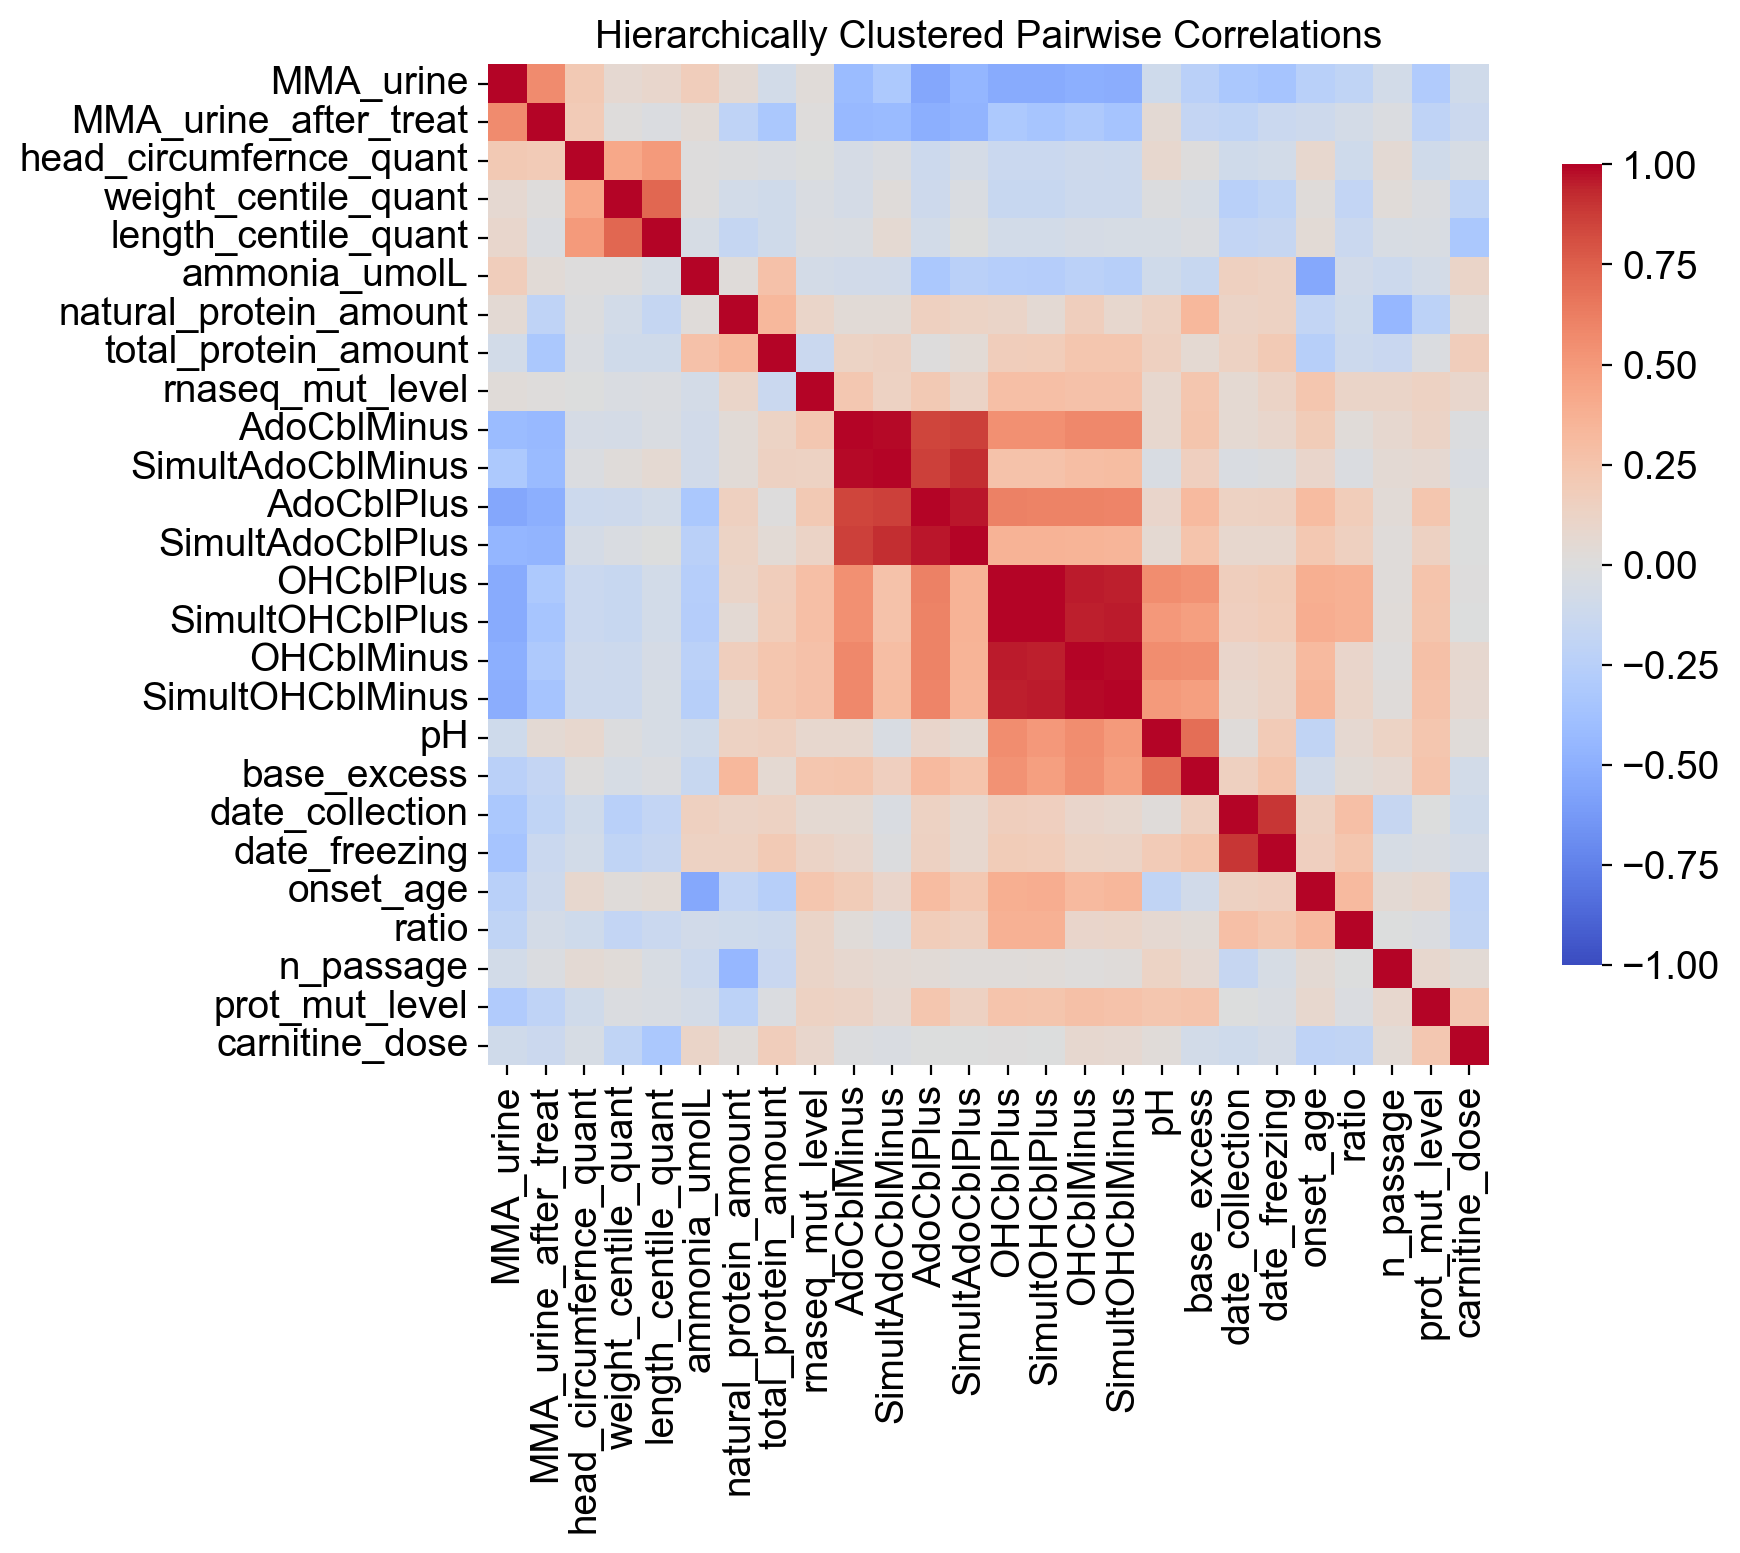

In [13]:
phenotypes.plot_clustered_correlation_heatmap(transformed_df)

From the correlations here we can spot a few block-diagonal patterns: AdoCbl assays are correlated, as are OHCbl assays, whih are in turn correlated with one another and anticorrelated with MMA excretion into the urine. With a structure like this we can try a covariation based imputation strategy like K-Nearest Neighbors and it should work decently.

In [14]:

# Create the imputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Fit and transform the data
imputed_array = imputer.fit_transform(transformed_df)
imputed_df = pd.DataFrame(imputed_array, columns=transformed_df.columns, index=transformed_df.index)

### Evaluating transformations and imputation

#### OHCblPlus

Based on guidance from Vito, we expect this measure to be bimodal following a transformation and for missing values to have high values (relatively normal enzymatic function). We didn't enforce these expectations but they are reflected the final results.

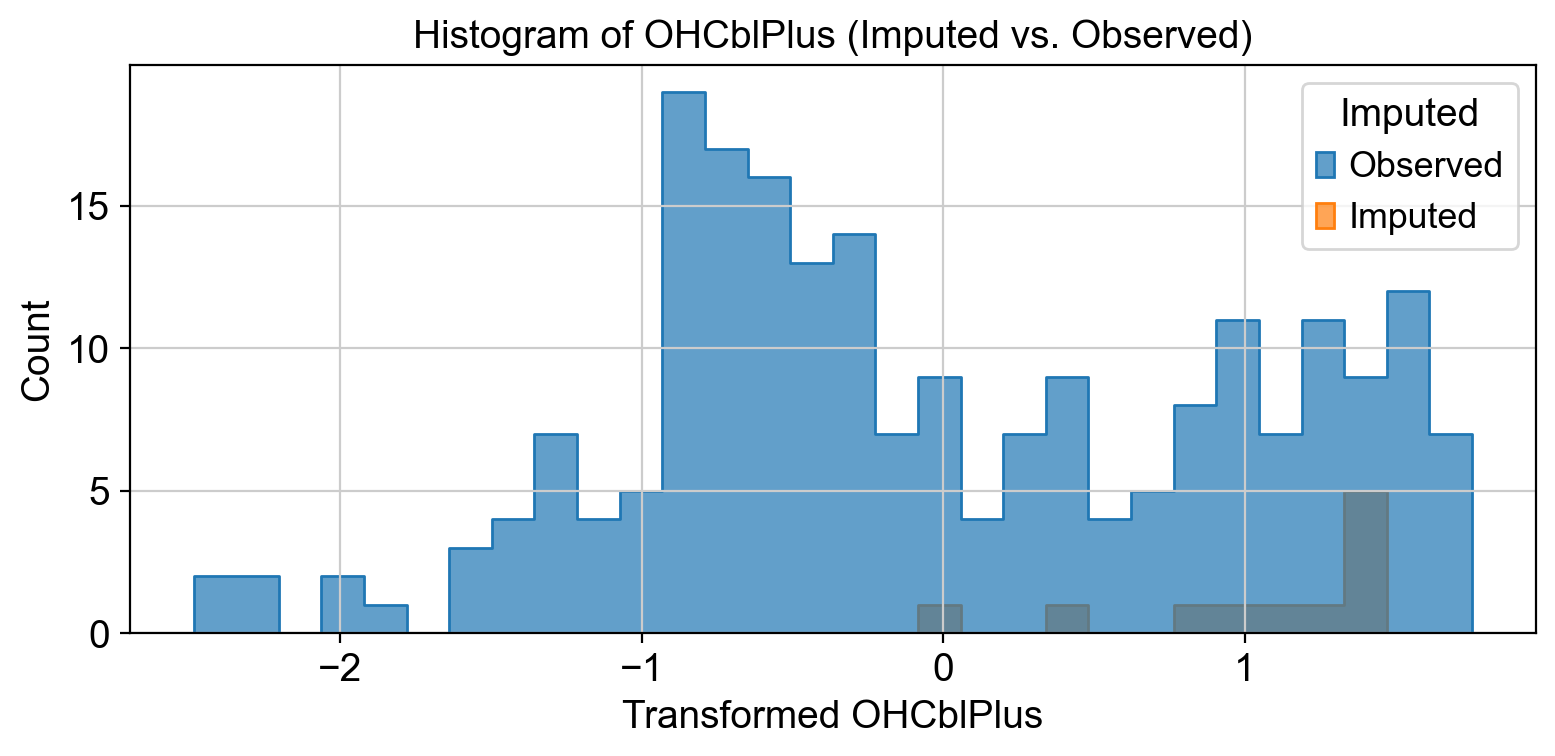

In [15]:
# Boolean mask: True if value was imputed
was_imputed = transformed_df["OHCblPlus"].isnull()

plot_df = pd.DataFrame({
    "OHCblPlus": imputed_df["OHCblPlus"],
    "Imputed": was_imputed.map({True: "Imputed", False: "Observed"})
})

plt.figure(figsize=(8, 4))
sns.histplot(
    data=plot_df,
    x="OHCblPlus",
    hue="Imputed",
    element="step",
    stat="count",
    common_norm=False,
    palette={"Observed": "tab:blue", "Imputed": "tab:orange"},
    alpha=0.7,
    bins = 30
)
plt.title("Histogram of OHCblPlus (Imputed vs. Observed)")
plt.xlabel("Transformed OHCblPlus")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Since the transformation selected for OHCblPlus, Yeo-Johnson, will be unfamiliar to many (myself included) we can visualize its distribution compare to the raw measurement and a log2 transformation. The Yeo-Johnson and log2 transformations are pretty similar, though the Yeo-Johnson transformation is if-anything making the distribution of OHCblPlus values more bimodality (nice).

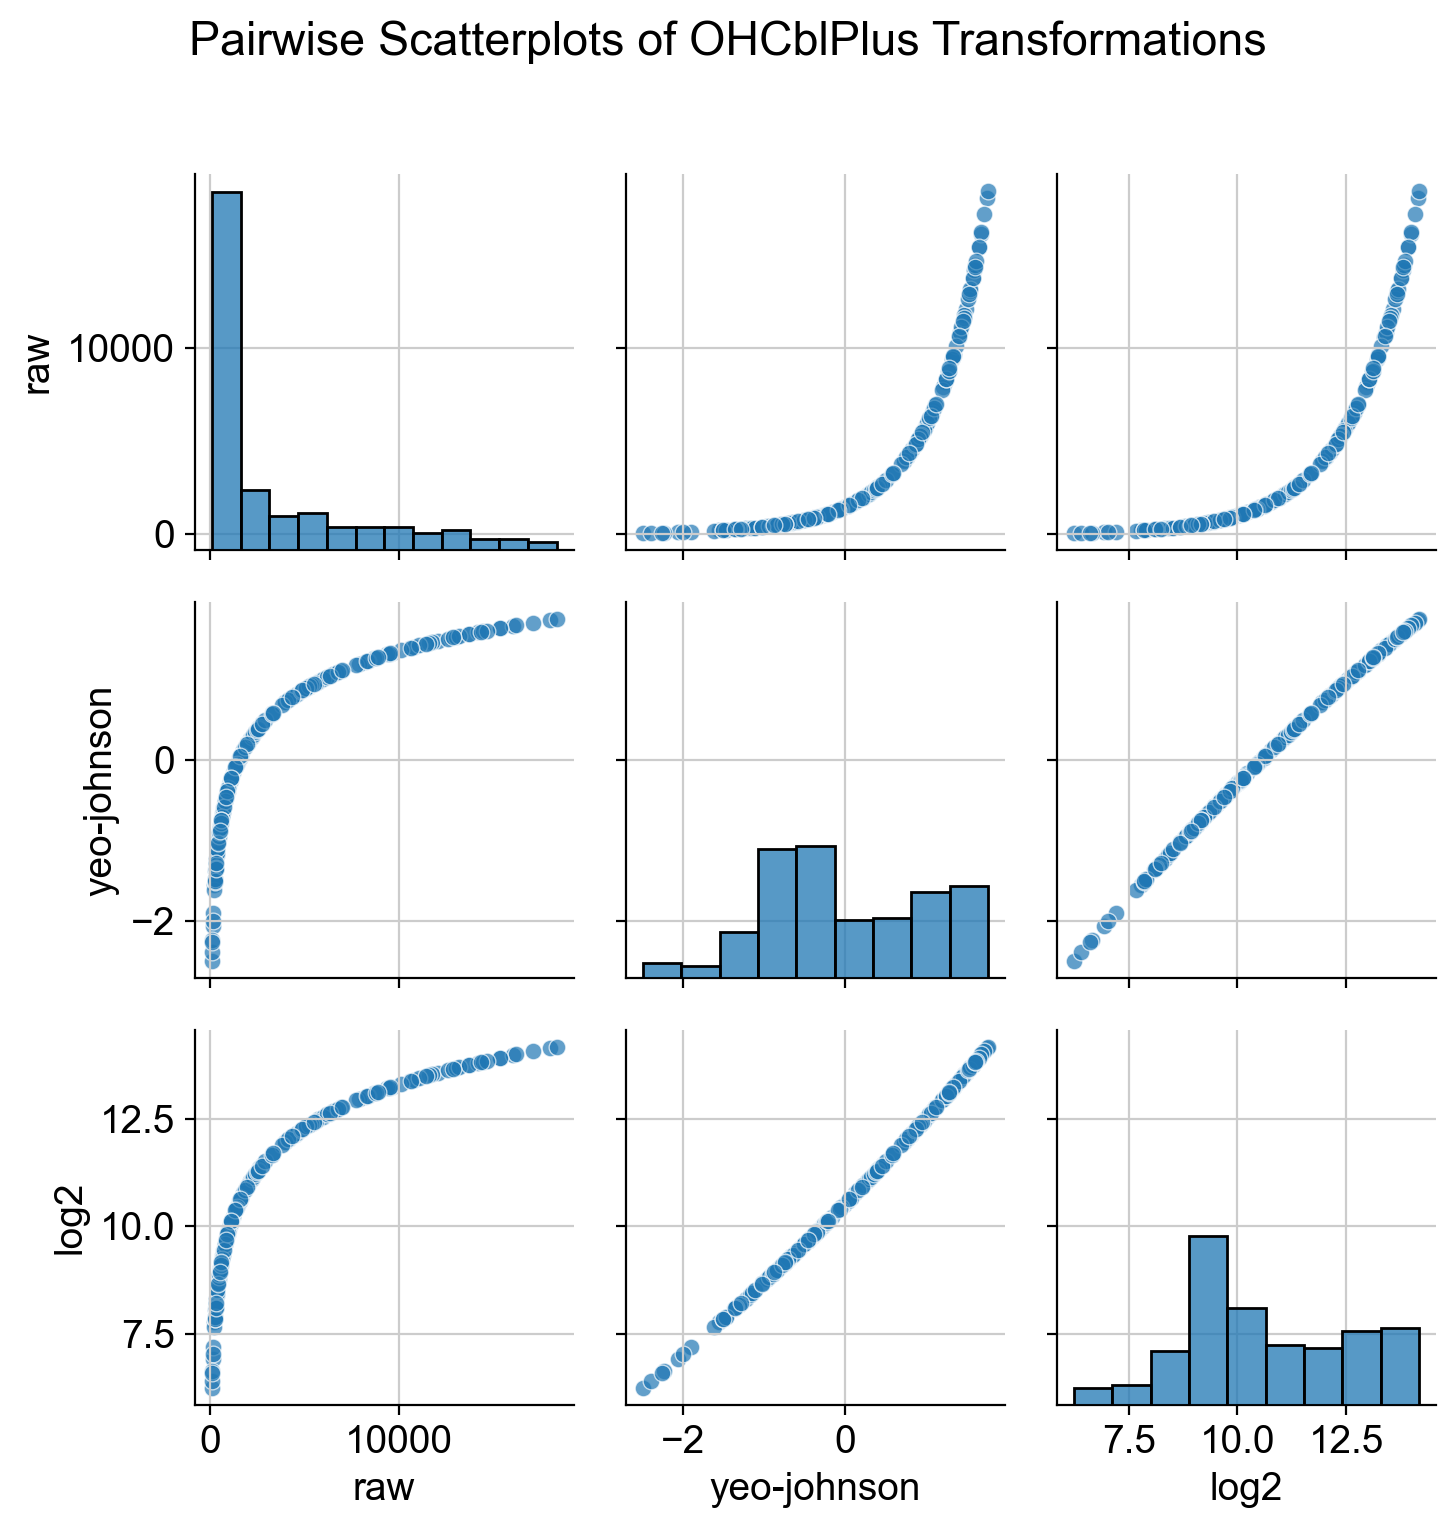

In [16]:
ohcbl_transformation_comparison = pd.DataFrame({
    "raw" : continuous_df["OHCblPlus"],
    "yeo-johnson": transformed_df["OHCblPlus"]
}) 
ohcbl_transformation_comparison["log2"] = [np.log2(x) for x in ohcbl_transformation_comparison["raw"]]

sns.pairplot(ohcbl_transformation_comparison, kind="scatter", diag_kind="hist", plot_kws={'alpha':0.7})
plt.suptitle("Pairwise Scatterplots of OHCblPlus Transformations", y=1.02)
plt.tight_layout()
plt.show()

#### Identifying Additional Biomarkers

From the phenotypic correlations it looks like there are a few groups of interesting phenotypes which are loosly (anti)-correlated with one another. 

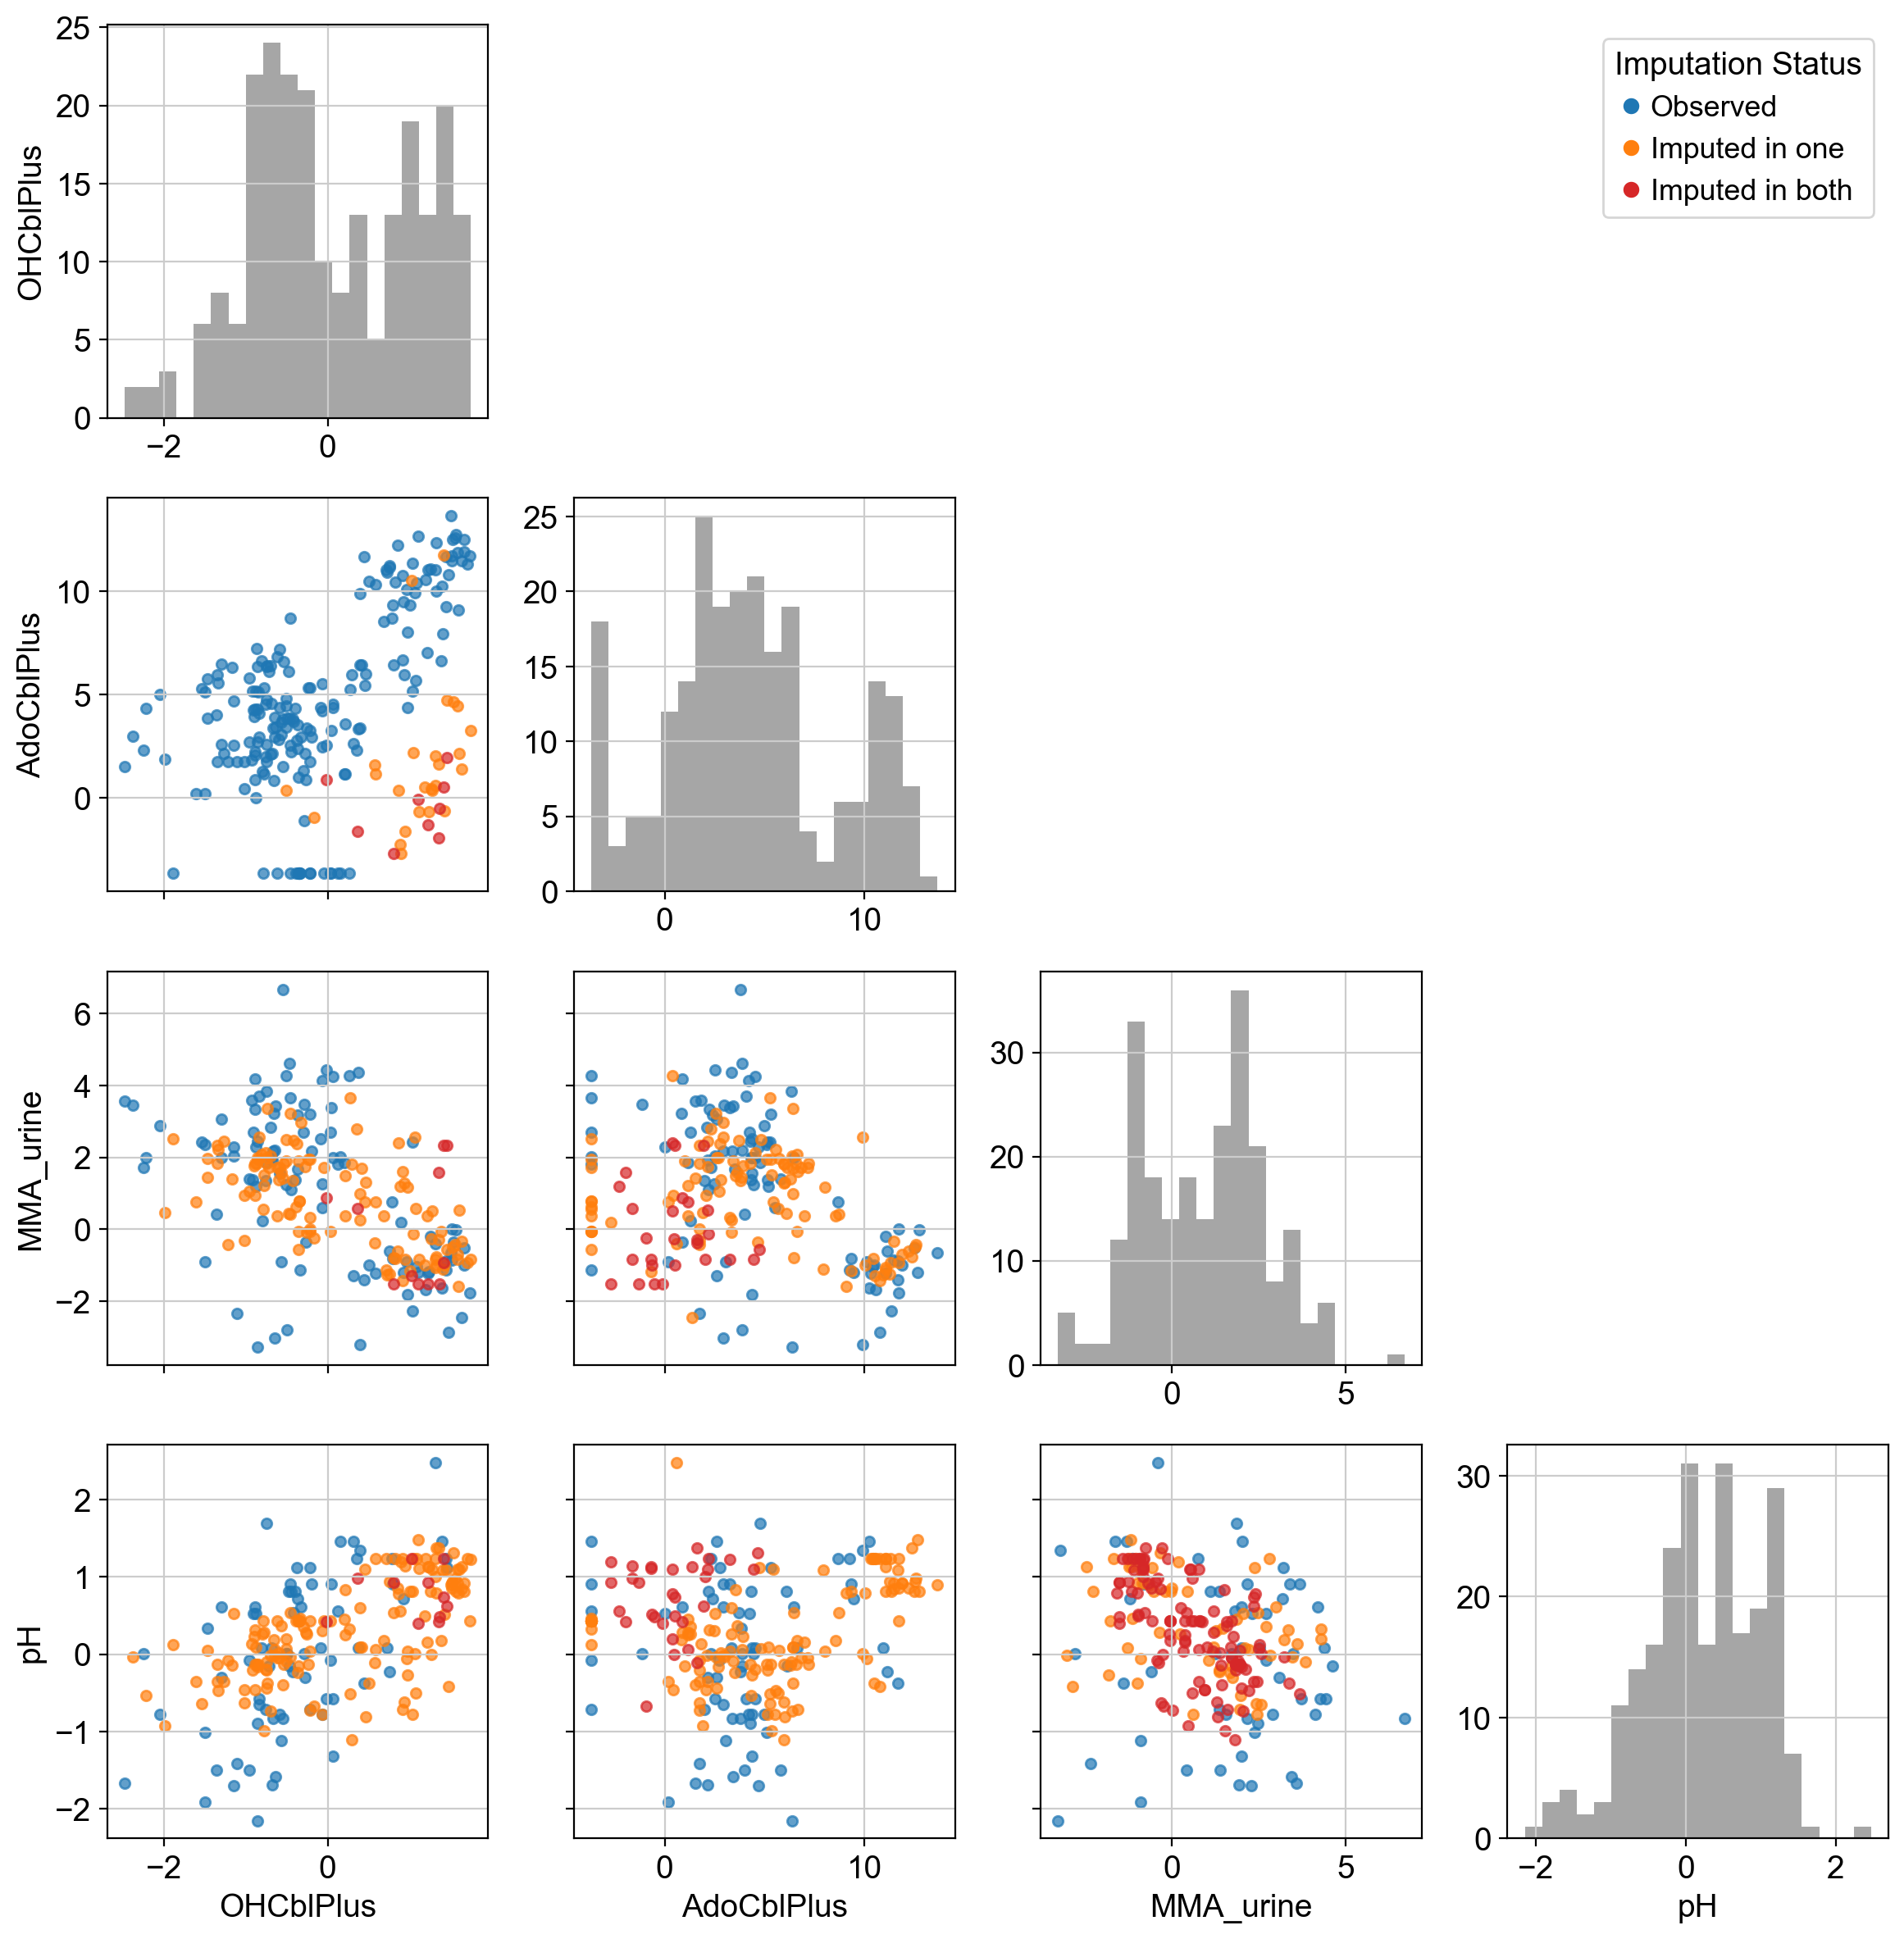

In [17]:
BIVARIATE_PHENOTYPES = ["OHCblPlus", "AdoCblPlus", "MMA_urine", "pH"]

phenotypes.lower_diag_pairgrid_with_imputation(imputed_df, transformed_df, BIVARIATE_PHENOTYPES)


### Summarizing phenotypes

Now that we have transformed many of the continuous measures we can construct a final phenotypes DataFrame including these transformations and high-value categorical varaibles.

In [27]:
binary_phenotypes = supplemental_data["phenotypes"][[col for col in supplemental_data["phenotypes"].columns if supplemental_data["phenotypes"][col].dropna().nunique() == 2]]

phenotypes_df = pd.concat([
    binary_phenotypes,
    imputed_df
], axis = 1)

## MuData Formatting

To make Napistu more accessible we'd like to lean more heavily on common data structures in genomics. One of these is the AnnData format and its extension to multiomic data MuData. AnnData objects can store lots of types of information, but at their core is observation- and feature-level metadata and a one or more data matrices.

Anndata results don't actually require an observation matrix, which is a nice feature for Napistu because for some results such as drug-screen results or QTLs the data would be better represented with feature attributes eschewing observation-level annoations.

In [28]:
transcr_adata = ad.AnnData(
    X = supplemental_data["transcriptomics"].T,
    # some samples are missing
    obs = phenotypes_df.loc[phenotypes_df.index.isin(supplemental_data["transcriptomics"].columns)],
    )

In [29]:
protein_metadata_vars = supplemental_data["proteomics"].columns[supplemental_data["proteomics"].columns.str.startswith("PG")]

proteomics_adata = ad.AnnData(
    # drop protein metadata vars and transpose
    X = supplemental_data["proteomics"].drop(protein_metadata_vars, axis = 1).T,
    # some samples are missing
    obs = phenotypes_df.loc[phenotypes_df.index.isin(supplemental_data["proteomics"].columns)],
    var = supplemental_data["proteomics"][protein_metadata_vars],
    )

In [31]:
mdata = MuData({"transcriptomics": transcr_adata, "proteomics": proteomics_adata})
mdata

/Users/maya/Desktop/GITHUB/napistu/lib/napistu-scrapyard/applications/forny_2023/.venv/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/maya/Desktop/GITHUB/napistu/lib/napistu-scrapyard/applications/forny_2023/.venv/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 230 × 19537
  2 modalities
    transcriptomics:	221 x 14749
      obs:	'case', 'gender', 'consanguinity', 'mut_category', 'wgs_zygosity', 'acidosis', 'metabolic_acidosis', 'metabolic_ketoacidosis', 'ketosis', 'hyperammonemia', 'abnormal_muscle_tone', 'musc_hypotonia', 'musc_hypertonia', 'fct_respiratory_abnormality', 'dyspnea', 'tachypnea', 'reduced_consciousness', 'lethargy', 'coma', 'seizures', 'general_tonic_clonic_seizure', 'any_GI_problem', 'failure_to_thrive', 'any_delay', 'behavioral_abnormality', 'concurrent_infection', 'urine_ketones', 'dialysis', 'peritoneal_dialysis', 'insulin', 'diet', 'carnitine', 'cobalamin', 'bicarb', 'glucose_IV', 'cobalamin_responsive', 'antibiotic_treatment', 'protein_restriction', 'tube_feeding_day', 'tube_feeding_night', 'tube_feeding_overall', 'language_delay', 'any_neurological_abnormalities_chronic', 'impaired_kidney_fct', 'hemat_abnormality', 'anemia', 'neutropenia', 'skin_abnormalities', 'hearing_impairment', 'osteoporosis', 'failure_to_thrive_chronic', 'global_dev_delay_chr', 'hypotonia_chr', 'basal_ganglia_abnormality_chr', 'failure_to_thrive_or_tube_feeding', 'irritability', 'hyperventilation', 'hypothermia', 'somnolence', 'vomiting', 'dehydration', 'feeding_problem', 'responsive_to_acute_treatment', 'n_passage', 'date_collection', 'date_freezing', 'onset_age', 'OHCblMinus', 'OHCblPlus', 'ratio', 'SimultOHCblMinus', 'SimultOHCblPlus', 'AdoCblMinus', 'AdoCblPlus', 'SimultAdoCblMinus', 'SimultAdoCblPlus', 'prot_mut_level', 'rnaseq_mut_level', 'MMA_urine', 'ammonia_umolL', 'pH', 'base_excess', 'MMA_urine_after_treat', 'carnitine_dose', 'natural_protein_amount', 'total_protein_amount', 'weight_centile_quant', 'length_centile_quant', 'head_circumfernce_quant'
    proteomics:	230 x 4788
      obs:	'case', 'gender', 'consanguinity', 'mut_category', 'wgs_zygosity', 'acidosis', 'metabolic_acidosis', 'metabolic_ketoacidosis', 'ketosis', 'hyperammonemia', 'abnormal_muscle_tone', 'musc_hypotonia', 'musc_hypertonia', 'fct_respiratory_abnormality', 'dyspnea', 'tachypnea', 'reduced_consciousness', 'lethargy', 'coma', 'seizures', 'general_tonic_clonic_seizure', 'any_GI_problem', 'failure_to_thrive', 'any_delay', 'behavioral_abnormality', 'concurrent_infection', 'urine_ketones', 'dialysis', 'peritoneal_dialysis', 'insulin', 'diet', 'carnitine', 'cobalamin', 'bicarb', 'glucose_IV', 'cobalamin_responsive', 'antibiotic_treatment', 'protein_restriction', 'tube_feeding_day', 'tube_feeding_night', 'tube_feeding_overall', 'language_delay', 'any_neurological_abnormalities_chronic', 'impaired_kidney_fct', 'hemat_abnormality', 'anemia', 'neutropenia', 'skin_abnormalities', 'hearing_impairment', 'osteoporosis', 'failure_to_thrive_chronic', 'global_dev_delay_chr', 'hypotonia_chr', 'basal_ganglia_abnormality_chr', 'failure_to_thrive_or_tube_feeding', 'irritability', 'hyperventilation', 'hypothermia', 'somnolence', 'vomiting', 'dehydration', 'feeding_problem', 'responsive_to_acute_treatment', 'n_passage', 'date_collection', 'date_freezing', 'onset_age', 'OHCblMinus', 'OHCblPlus', 'ratio', 'SimultOHCblMinus', 'SimultOHCblPlus', 'AdoCblMinus', 'AdoCblPlus', 'SimultAdoCblMinus', 'SimultAdoCblPlus', 'prot_mut_level', 'rnaseq_mut_level', 'MMA_urine', 'ammonia_umolL', 'pH', 'base_excess', 'MMA_urine_after_treat', 'carnitine_dose', 'natural_protein_amount', 'total_protein_amount', 'weight_centile_quant', 'length_centile_quant', 'head_circumfernce_quant'
      var:	'PG.ProteinDescriptions', 'PG.ProteinNames', 'PG.Qvalue'

## Transformation and Normalization

Now that the datasets are incorporated in a AnnData/MuData objects we can manipulate them to in-place to make the data more Gaussian and to decrease the influence of non-biologicalop variation. 

From the paper, it sounds like the data was logged and normalization was approached by iteratively centering rows and columns until both were zero centered. Here, we'll try to follow the same logic.

### Filtering poorly measured features

First, we'll filter the RNAseq data since it includes some genes with very few reads.

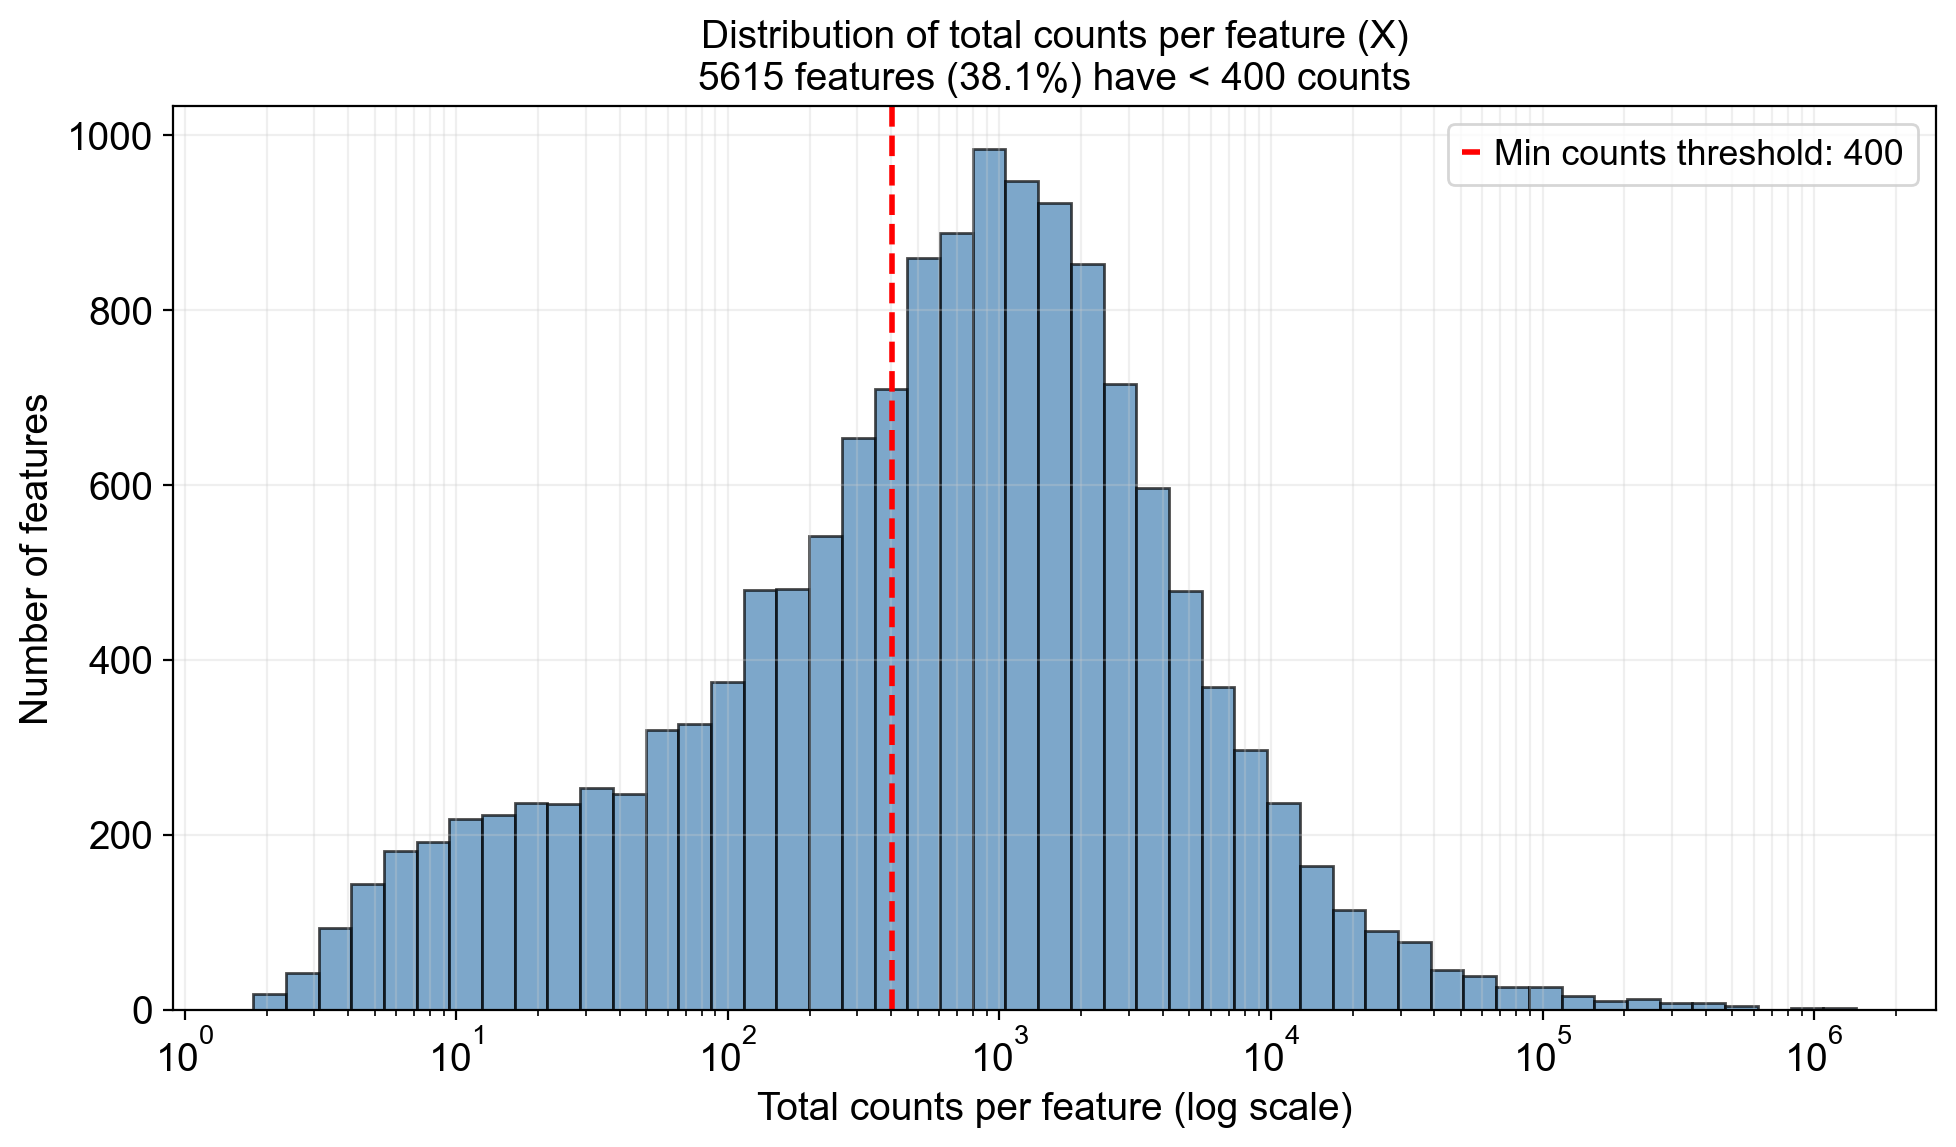

In [32]:
processing.plot_feature_counts_histogram(mdata["transcriptomics"], min_counts = READ_CUTOFF)
plt.show()

In [33]:
# filter to drop features with low counts
processing.filter_features_by_counts(mdata["transcriptomics"], min_counts = READ_CUTOFF)

## Log-transformation

Plot out some of the features they look pretty darn log-Normal and this generally a fair assumption for transcript- or protein-level data.

In [34]:
# add a pseudocount before logging
processing.log2_transform(mdata["transcriptomics"], pseudocount = 1)
# proteomics has a minimum value of 1 so no pseudocounts are needed before logging
processing.log2_transform(mdata["proteomics"], pseudocount = 0)

### Normalization

Apply iterative row and column centering as-per Forny et al., 2023.

In [35]:
processing.center_rows_and_columns_mudata(
    mdata,
    layer = "log2",
    new_layer_name = "log2_centered"
)

In [36]:
mdata

MuData object with n_obs × n_vars = 230 × 19537
  2 modalities
    transcriptomics:	221 x 9134
      obs:	'case', 'gender', 'consanguinity', 'mut_category', 'wgs_zygosity', 'acidosis', 'metabolic_acidosis', 'metabolic_ketoacidosis', 'ketosis', 'hyperammonemia', 'abnormal_muscle_tone', 'musc_hypotonia', 'musc_hypertonia', 'fct_respiratory_abnormality', 'dyspnea', 'tachypnea', 'reduced_consciousness', 'lethargy', 'coma', 'seizures', 'general_tonic_clonic_seizure', 'any_GI_problem', 'failure_to_thrive', 'any_delay', 'behavioral_abnormality', 'concurrent_infection', 'urine_ketones', 'dialysis', 'peritoneal_dialysis', 'insulin', 'diet', 'carnitine', 'cobalamin', 'bicarb', 'glucose_IV', 'cobalamin_responsive', 'antibiotic_treatment', 'protein_restriction', 'tube_feeding_day', 'tube_feeding_night', 'tube_feeding_overall', 'language_delay', 'any_neurological_abnormalities_chronic', 'impaired_kidney_fct', 'hemat_abnormality', 'anemia', 'neutropenia', 'skin_abnormalities', 'hearing_impairment', 'osteoporosis', 'failure_to_thrive_chronic', 'global_dev_delay_chr', 'hypotonia_chr', 'basal_ganglia_abnormality_chr', 'failure_to_thrive_or_tube_feeding', 'irritability', 'hyperventilation', 'hypothermia', 'somnolence', 'vomiting', 'dehydration', 'feeding_problem', 'responsive_to_acute_treatment', 'n_passage', 'date_collection', 'date_freezing', 'onset_age', 'OHCblMinus', 'OHCblPlus', 'ratio', 'SimultOHCblMinus', 'SimultOHCblPlus', 'AdoCblMinus', 'AdoCblPlus', 'SimultAdoCblMinus', 'SimultAdoCblPlus', 'prot_mut_level', 'rnaseq_mut_level', 'MMA_urine', 'ammonia_umolL', 'pH', 'base_excess', 'MMA_urine_after_treat', 'carnitine_dose', 'natural_protein_amount', 'total_protein_amount', 'weight_centile_quant', 'length_centile_quant', 'head_circumfernce_quant'
      uns:	'feature_filtering', 'log2_transform'
      layers:	'log2', 'log2_centered'
    proteomics:	230 x 4788
      obs:	'case', 'gender', 'consanguinity', 'mut_category', 'wgs_zygosity', 'acidosis', 'metabolic_acidosis', 'metabolic_ketoacidosis', 'ketosis', 'hyperammonemia', 'abnormal_muscle_tone', 'musc_hypotonia', 'musc_hypertonia', 'fct_respiratory_abnormality', 'dyspnea', 'tachypnea', 'reduced_consciousness', 'lethargy', 'coma', 'seizures', 'general_tonic_clonic_seizure', 'any_GI_problem', 'failure_to_thrive', 'any_delay', 'behavioral_abnormality', 'concurrent_infection', 'urine_ketones', 'dialysis', 'peritoneal_dialysis', 'insulin', 'diet', 'carnitine', 'cobalamin', 'bicarb', 'glucose_IV', 'cobalamin_responsive', 'antibiotic_treatment', 'protein_restriction', 'tube_feeding_day', 'tube_feeding_night', 'tube_feeding_overall', 'language_delay', 'any_neurological_abnormalities_chronic', 'impaired_kidney_fct', 'hemat_abnormality', 'anemia', 'neutropenia', 'skin_abnormalities', 'hearing_impairment', 'osteoporosis', 'failure_to_thrive_chronic', 'global_dev_delay_chr', 'hypotonia_chr', 'basal_ganglia_abnormality_chr', 'failure_to_thrive_or_tube_feeding', 'irritability', 'hyperventilation', 'hypothermia', 'somnolence', 'vomiting', 'dehydration', 'feeding_problem', 'responsive_to_acute_treatment', 'n_passage', 'date_collection', 'date_freezing', 'onset_age', 'OHCblMinus', 'OHCblPlus', 'ratio', 'SimultOHCblMinus', 'SimultOHCblPlus', 'AdoCblMinus', 'AdoCblPlus', 'SimultAdoCblMinus', 'SimultAdoCblPlus', 'prot_mut_level', 'rnaseq_mut_level', 'MMA_urine', 'ammonia_umolL', 'pH', 'base_excess', 'MMA_urine_after_treat', 'carnitine_dose', 'natural_protein_amount', 'total_protein_amount', 'weight_centile_quant', 'length_centile_quant', 'head_circumfernce_quant'
      var:	'PG.ProteinDescriptions', 'PG.ProteinNames', 'PG.Qvalue'
      uns:	'log2_transform'
      layers:	'log2', 'log2_centered'

## Exploratory Data Analysis

Before digging into the results of the study its a good idea to understand the major factors driving the studies variation. Ideally, these are the variables of interest (i.e, case) but to the extent this is not true then we may have to add additional covariates or hunt for batch effects. Its also a good idea to generate a scree plot to see whether the variation is driven by a few known or unknown variables or if there are many sources of variation. Since this study has a large number of patient-derived samples I'm guessing we're in the latter scenario.

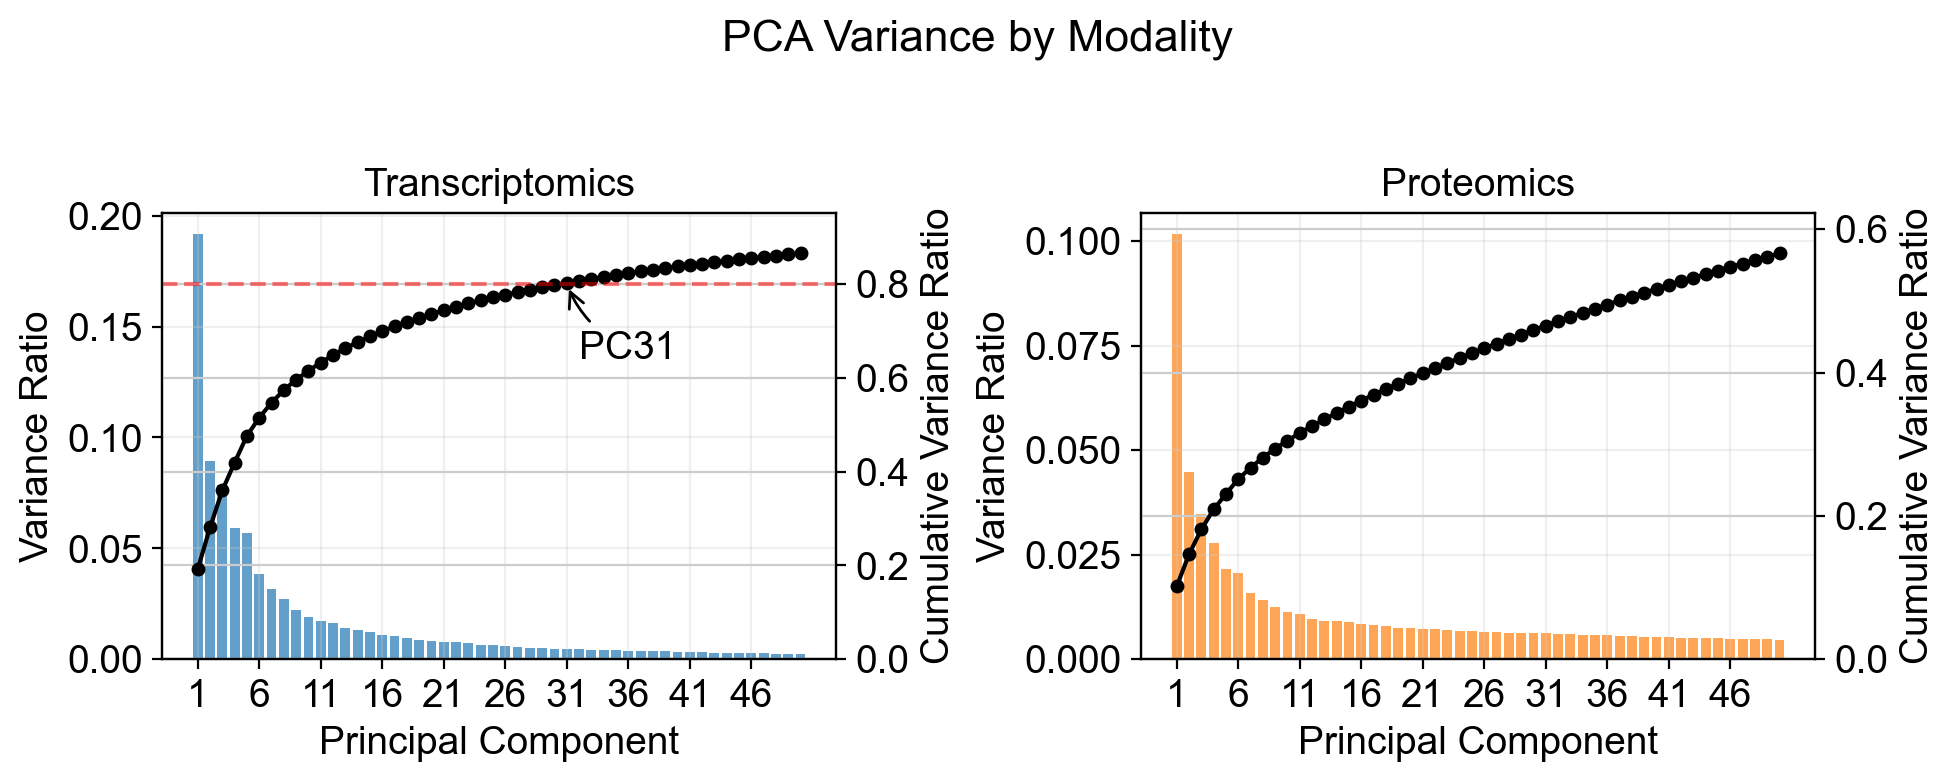

In [37]:
import scanpy as sc

# Process each modality
for modality in ['transcriptomics', 'proteomics']:
    # add PCs
    sc.pp.pca(mdata[modality], layer = ANALYSIS_LAYER)
    
eda.plot_mudata_pca_variance(mdata, n_pcs = int(50))
plt.show()

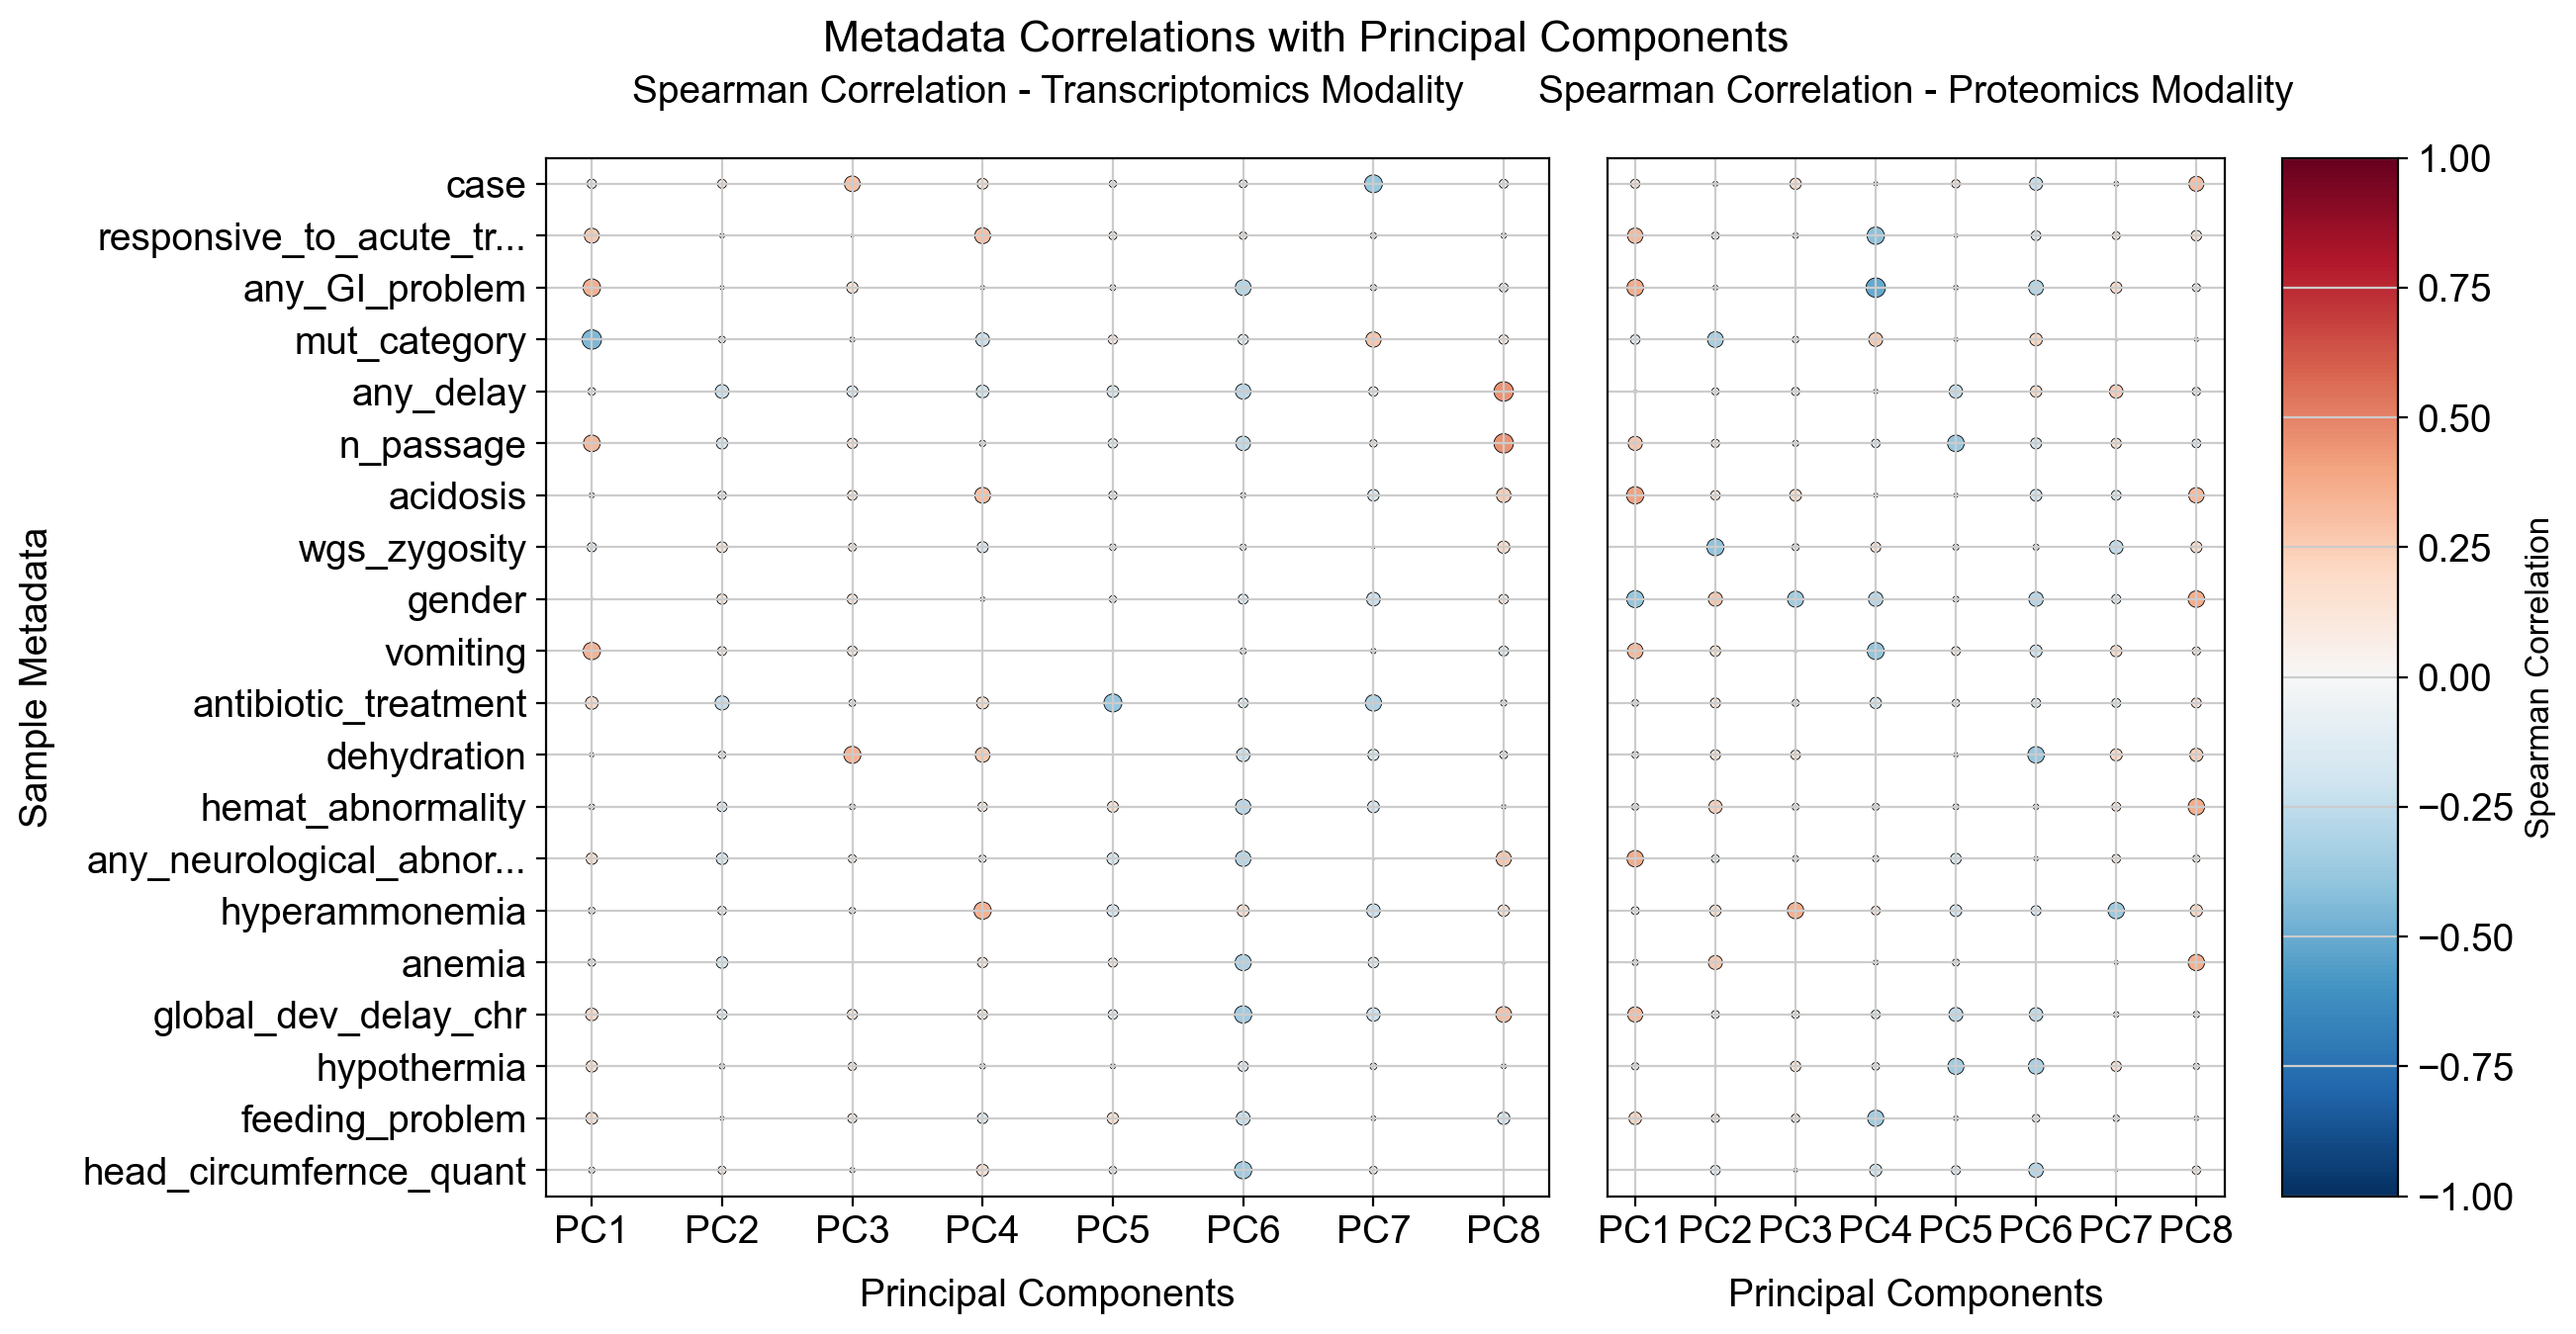

In [50]:

PRIORITIZED_PHENOTYPES = ["case", "OHCblPlus", "AdoCblPlus", "MMA_urine", "pH", "responsive_to_acute_treatment"]

# TO DO
# 1. I'm not sure why the numeric vars aren't showing up in this plot
# 2. Update regression to use 1 or more of these measures.
# 3. Update post factor analysis regression to link factors to these measures.

results = eda.analyze_pc_metadata_correlation_mudata(
    mdata,
    n_pcs=8,
    prioritized_vars=PRIORITIZED_PHENOTYPES,  # This will always show 'case' variable at the top
    pca_kwargs={'svd_solver': 'arpack'},
    
    figsize = (12, 7)
)

plt.show()

Processing transcriptomics modality...
Processing proteomics modality...


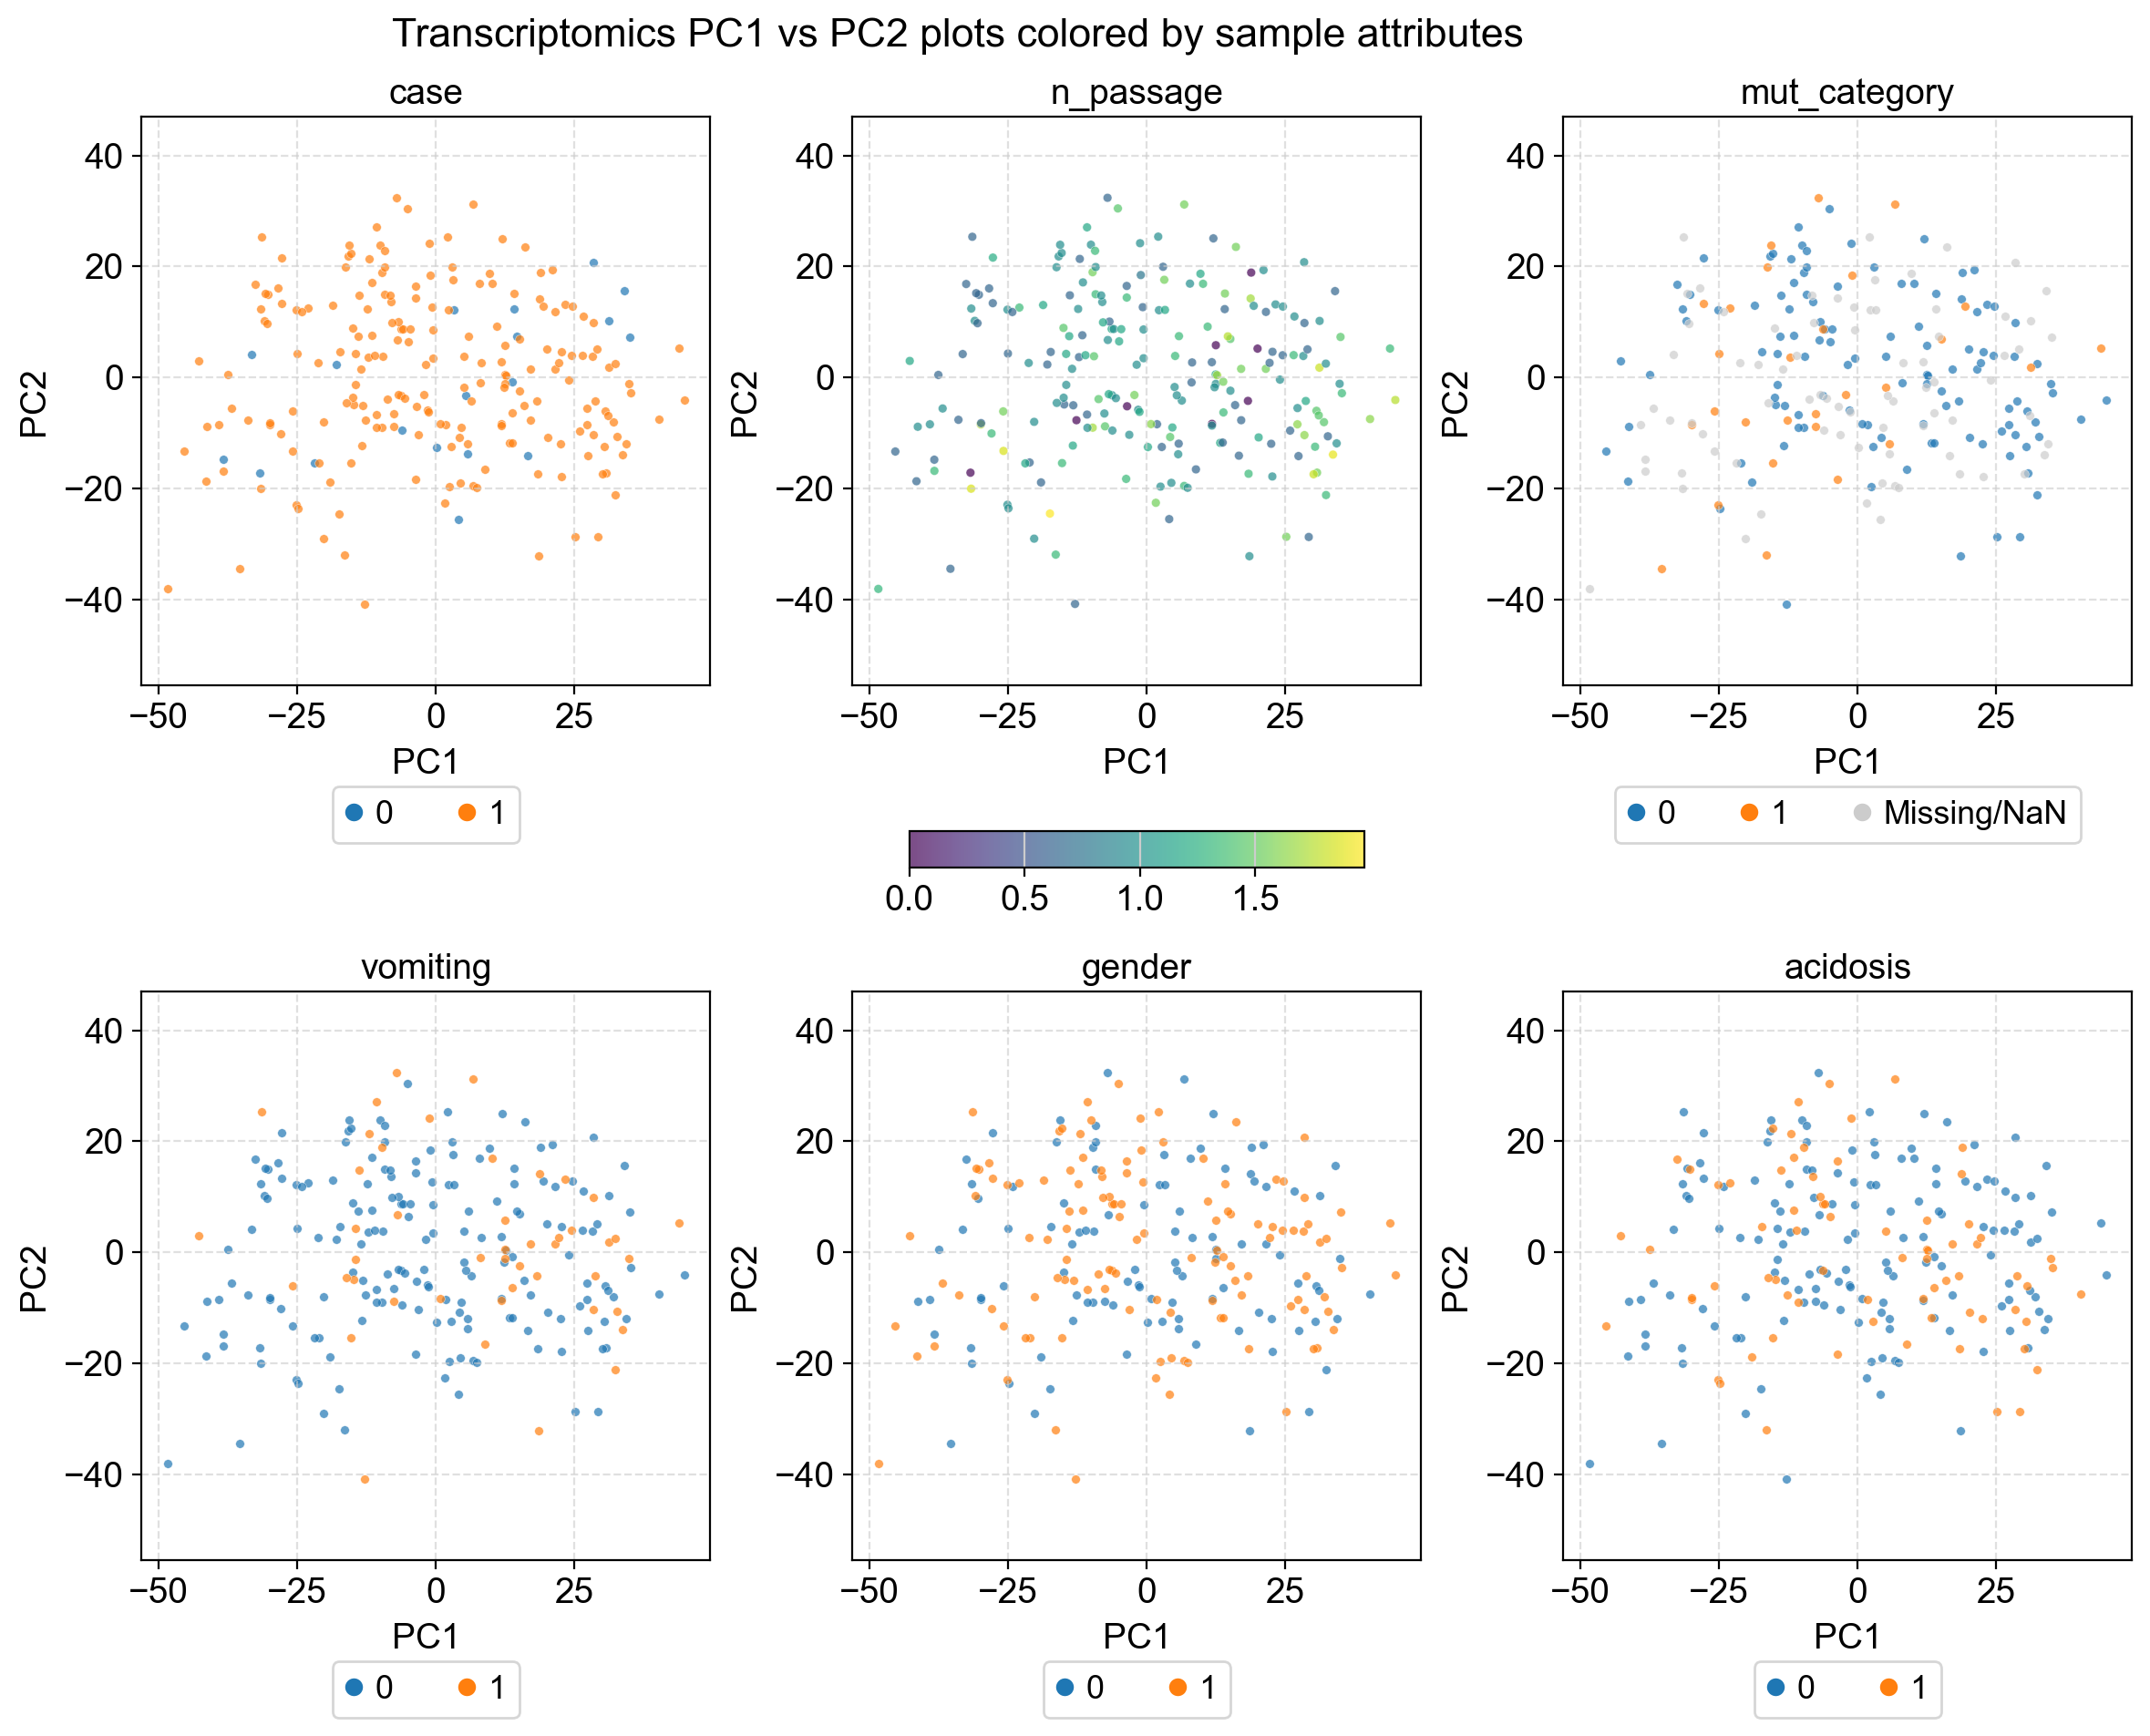

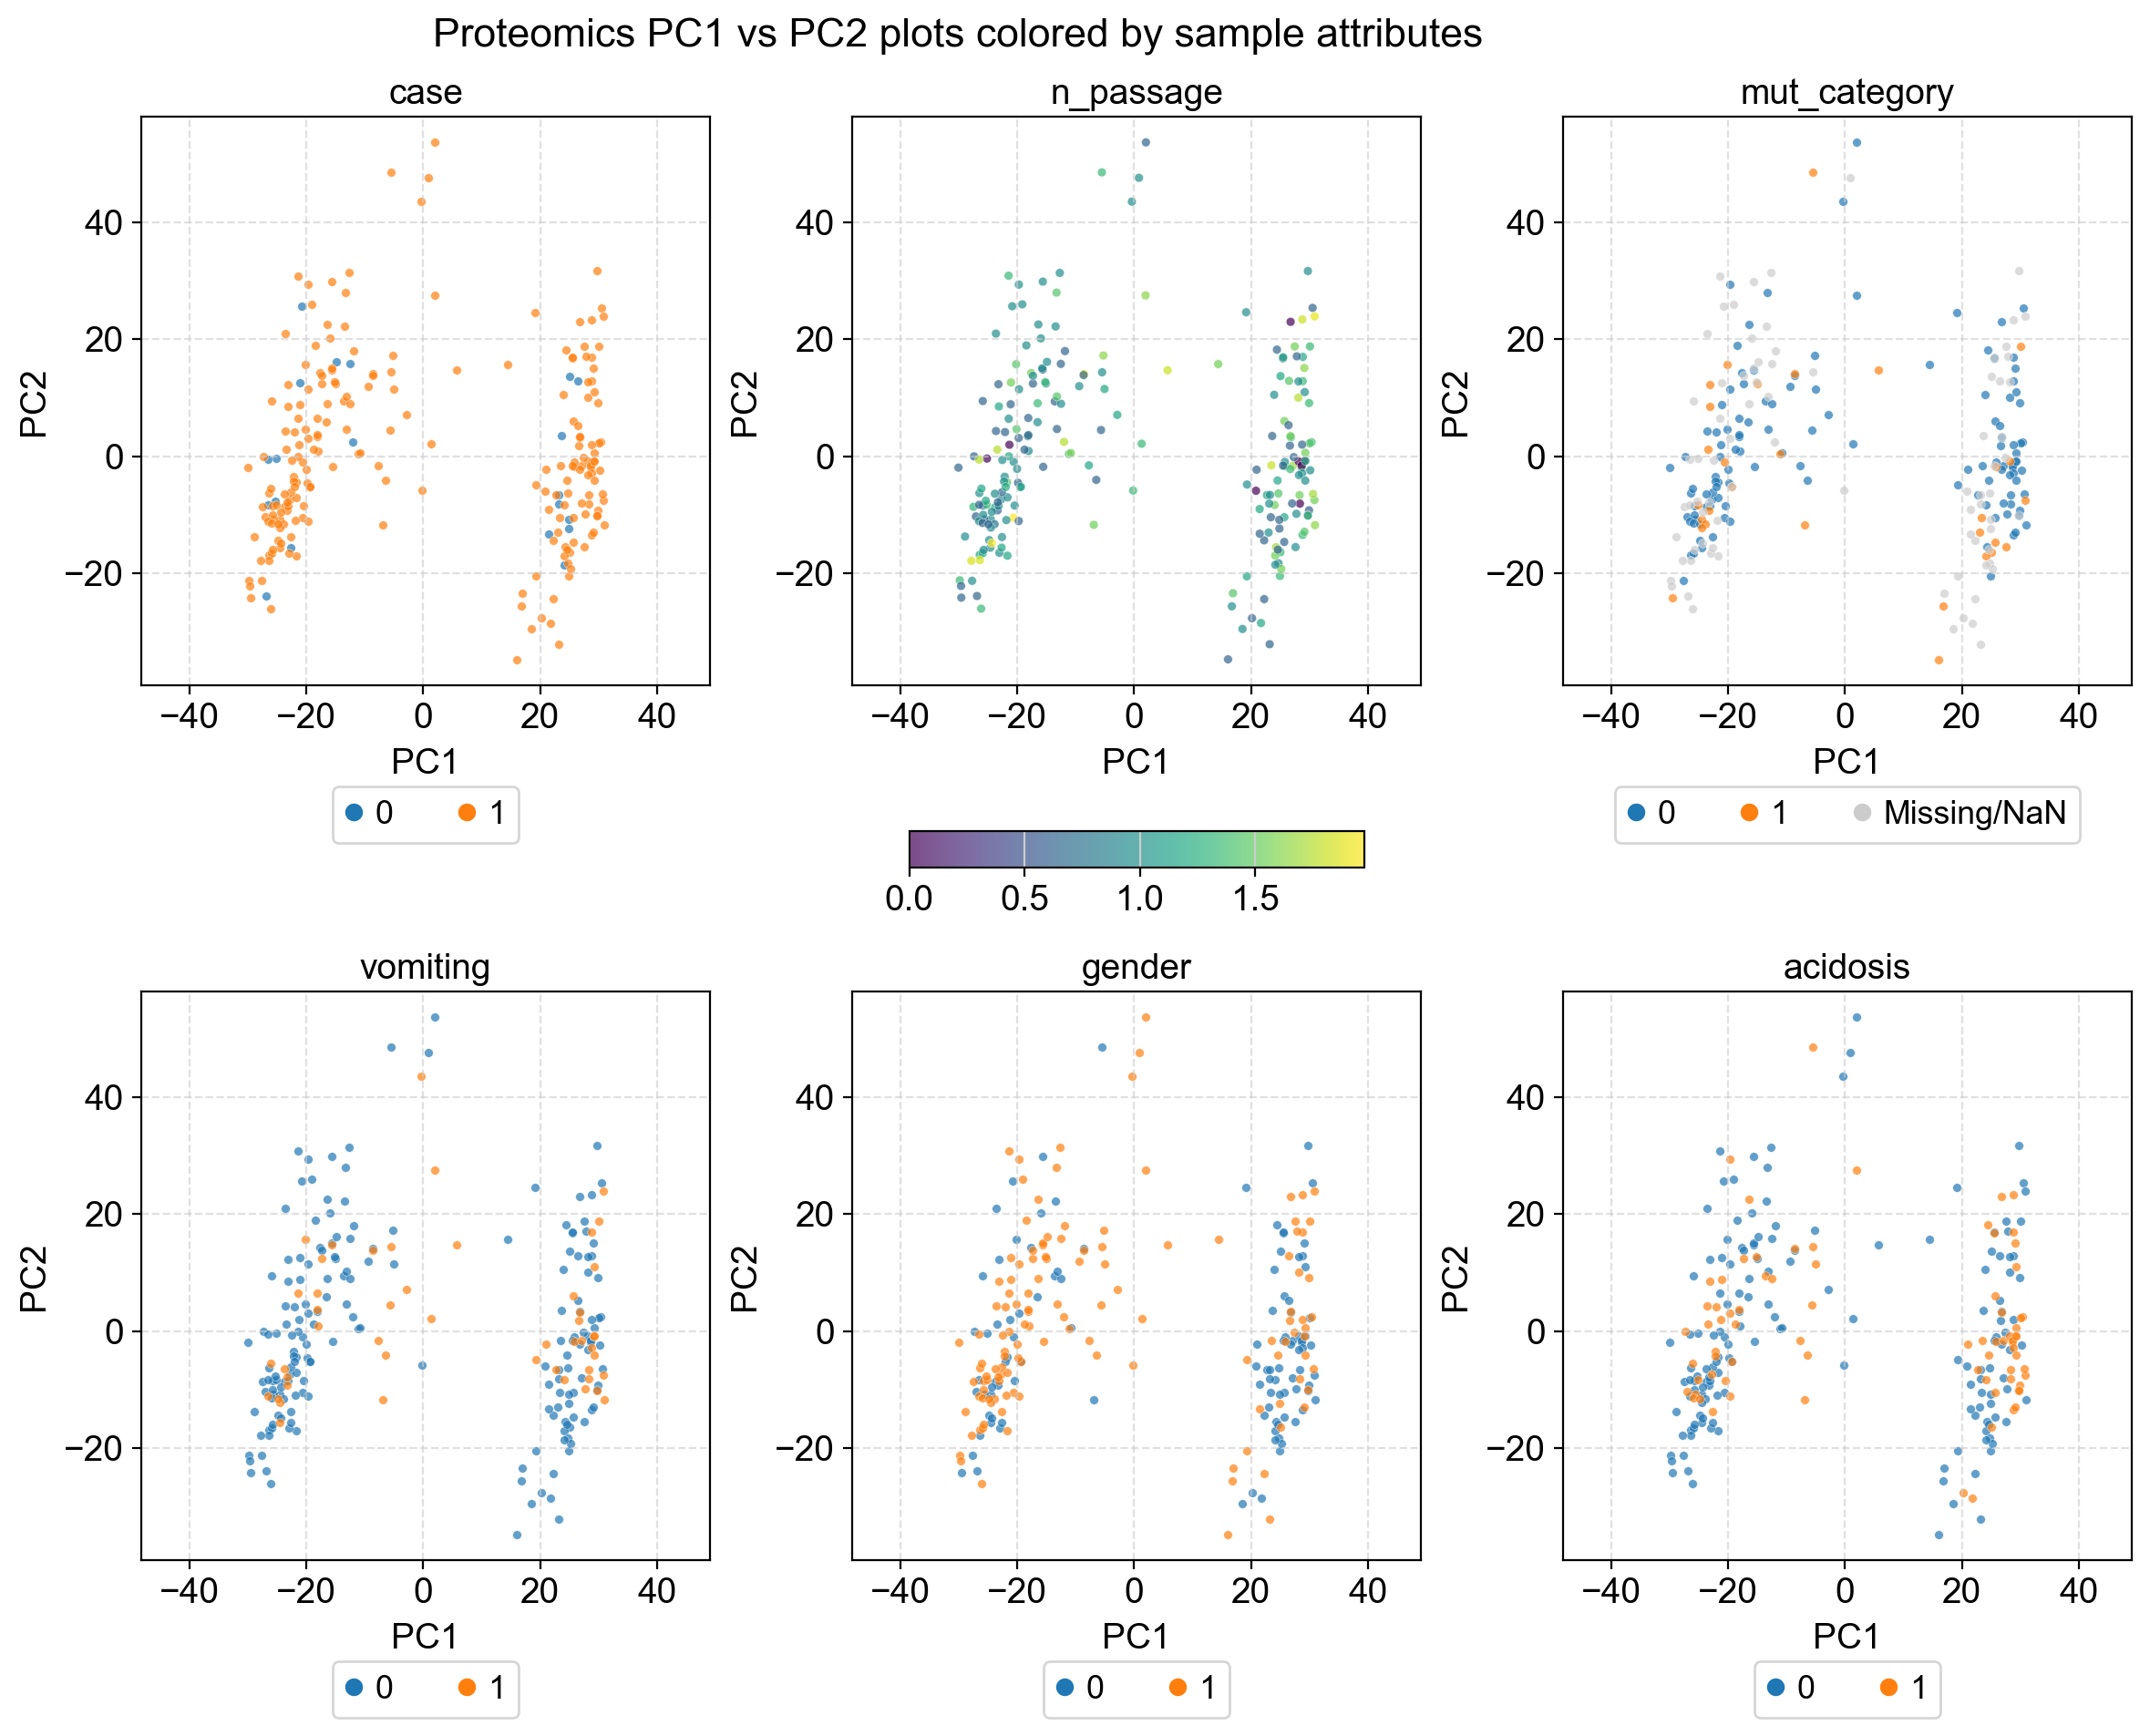

In [39]:
SAMPLE_ATTRIBUTES = ["case", "n_passage", "mut_category","vomiting", "gender", "acidosis"]

eda.plot_mudata_pcs(
    mdata, 
    metadata_attrs=SAMPLE_ATTRIBUTES,
    figsize = (14, 10),
    point_size = 12,
    legend = True
)
plt.show()

In [ ]:
eda.plot_mudata_pcs(mdata, metadata_attrs = "case", pc_x = 3, pc_y = 7)
plt.show()

From the exploratory data analysis we can make a few observations about the dataset(s):

1. From the Screeplot it is clear that there are complex sources of variation in these datasets - from the elbow of the plot, there are likely 8-10 major principal components but even this number only captures 50-60% of the variation in the datasets.
2. The lower fraction of total variation explained in the proteomics than the transcriptomics datasets likely reflect higher technical variation in this dataset.
3. The PC corrplot, and followups plotting pairs of princial components highlight that the the primary attribute of interest, case (i.e, affecteds vs. unaffecteds), is a relatively minor driver of variation in the dataset. It shows up weakly correlated with PC3 in both the transcriptomics' and proteomics' datasets (note that the analysis of each modality is totally separate).
4. PC1 in the proteomics data is bimodal but the two categories do not map onto any of the provided covariates (e.g., gender). Ideally, we'd want to find or define a variable which nicely captures these two groups but I'm not familiar enough with this dataset to do so (I'm guessing its a modest technical batch effect). Unexplained variation of this magnitude is problematic but not a dealbreaker for downstream analyses like regression as it will decrease power and may increase bias depending on the correlation of case or other variables of interest to the latent variable.
5. PC1 in the transcriptomics data is also tricky to understand, there is a rough correlation with the # of passages a cell line has gone through and its mutational status. This may reflect biases in how cell lines are used (preserving those that are particularly precious by putting them through fewer passages) or shifts in the biology of the cell lines as they acclimate to laboratory conditions.

## Generating multi-omic profiles

To map our results onto Napistu network representations we need to generate a set of feature-level summaries. This can be done in multiple ways but for this analysis we'll use a supervised method, differential expression analysis, and an unsupervised one, factor analysis.

### Differential Expression Analysis

I've always done diffex in R, using data modality agnostic methods like regression, and modality-specific methods like DESeq2. It looks like there is a Python implementation of DESeq2 `pydeseq2.dds.DeseqDataSet` but since the transcript counts are not integers this framework is not appropriate. As a result we can just treat the transcripts and proteins equivalently and perform feature-wise regressions to estimate the effect of `case`.

In [ ]:
# List of modalities to process
modalities = ["transcriptomics", "proteomics"]  # Add other modalities as needed

# Process each modality
for modality in modalities:
    print(f"Processing {modality}...")
    
    # Skip if modality doesn't exist in the mdata object
    if modality not in mdata.mod:
        print(f"Modality {modality} not found in MuData object. Skipping.")
        continue
    
    # Apply regression per feature
    summaries = profiles.apply_regression_per_feature(
        mdata[modality],
        REGRESSION_FORMULA,
        n_jobs=4,
        layer = ANALYSIS_LAYER,
        progress_bar = False
    )
    
    # Add results to the AnnData object
    # TO DO - the unstructured results here prevent serialization to a .h5mu
    profiles.add_regression_results_to_anndata(
        mdata[modality],
        summaries,
        fdr_cutoff=FDR_CUTOFF
    )

In [ ]:
profiles.plot_pvalue_histograms(mdata)
plt.show()

We knew before applying regression analysis that cases were only loosly correlated with the leading PCs and there is also a large case imbalance with only ~12 unaffecteds.

It seems like the signal for `case` is really weak in general so it may not be the right measure for assessing disease biology, relative to a marker of disease severity like `onset_age` or `responsive_to_acute_treatment`.

The p-value histograms for gender show statistical significance in proteomics, and less-significance than expected by chance in the transcriptomics. This is pathological and suggests confounding (resulting in biased p-values) and/or unaccounted for covariates (as was already expected from EDA).


### Factor Analysis

Since we have two data modalities and we'd like to find patterns of covaration which span both data modalities we can 

In [ ]:
import muon

# update the MuData object so `nvars and `nobs` are appropriate`
intersected_mdata = MuData({k: v for k, v in mdata.mod.items()})

muon.pp.intersect_obs(intersected_mdata)  # This modifies mdata in-place

In [ ]:
# Run the factor scan
results_dict = factor_analysis.run_mofa_factor_scan(
    intersected_mdata, 
    factor_range=FACTOR_RANGE,
    use_layer=ANALYSIS_LAYER,  # Adjust to your normalized layer
    models_dir=MOFA_PARAM_SCAN_MODELS_PATH,
    overwrite=OVERWRITE
)

# Extract variance metrics from all models
metrics = factor_analysis.calculate_variance_metrics(results_dict)

factor_analysis.visualize_factor_scan_results(metrics, user_factors=OPTIMAL_FACTOR)

In [ ]:
import mudata as md

if not os.path.isfile(OPTIMAL_MODEL_H5MU_PATH) or OVERWRITE:

    optimal_model = factor_analysis.create_minimal_mudata(
        intersected_mdata,
        include_layers=[ANALYSIS_LAYER],
        include_obsm=True,
        include_varm=False
    )

    muon.tl.mofa(
        optimal_model,
        n_factors=OPTIMAL_FACTOR,
        use_obs=None,
        use_var=None,
        use_layer=ANALYSIS_LAYER,
        convergence_mode="medium",
        verbose=False,
        save_metadata=True
    )

    md.write_h5mu(OPTIMAL_MODEL_H5MU_PATH, optimal_model)
else:
    optimal_model = md.read_h5mu(OPTIMAL_MODEL_H5MU_PATH)


## Identifying interesting factors

We can generate network representations for each of these factors (based on feature loadings) but there are some that are probably more interesting than others. Ideally some factors capture batch-effects and variation which is independent of disease, while others reflect pathways whose activity varies across measures of MMA pathology (e.g., cases vs. controls).

To identify interesting factors we can compare the the sample usages to disease covariates. Regression is a good way of approaching this but first we need to assess whether loadings are Normally-distributions (technically, just the residuals have to be but the disease influence is relatively weak).

In [ ]:
# Plot histograms for all factors
factor_analysis.plot_mofa_factor_histograms(optimal_model)
plt.show()

In [ ]:
# Run regression analysis
regression_results = factor_analysis.regress_factors_with_formula(
    optimal_model,
    formula=REGRESSION_FORMULA,
    factors=None  # Use all factors
)

# Generate summary table
summary_table = factor_analysis.summarize_factor_regression(
    regression_results,
    alpha=FDR_CUTOFF,
    group_by_factor=True
)

# Add results to MuData object
factor_analysis.add_regression_to_mudata(
    optimal_model,
    regression_results,
    key_added="factor_regression"
)

In [ ]:
regression_results.sort_values("q_value").head(10)